In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from sklearn.tree import DecisionTreeClassifier, _tree, plot_tree
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ Libraries imported")

✓ Libraries imported


In [2]:
feature_names = pd.read_csv('../column_order_401_9_jan.csv')['features'].tolist()

with open('../model_401_9_jan.pkl', 'rb') as f:
    model = pickle.load(f)

# Assign feature names to the booster
booster = model.get_booster()
booster.feature_names = feature_names
model.gpu_id = None
model.predictor = None
model.use_label_encoder = None

# np.array(feature_names)[np.argsort(model.feature_importances_)[::-1]]

[16:48:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



In [3]:
# Load and prepare data
df = pd.read_parquet('../actual_data.parquet')
print(f"✓ Data loaded: {df.shape}")

# Clean data
df = df.replace([np.inf, -np.inf], np.nan)
for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')
df = df.fillna(-99999)

# Date splits
june_2024_end = pd.Timestamp('2024-06-30')
july_2024_end = pd.Timestamp('2024-07-31')
august_2024_end = pd.Timestamp('2024-08-31')

train_df = df[pd.to_datetime(df['CUTOFF_DATE']) <= june_2024_end].query("EVER_4DPD_IN_120DAYS != -99999").copy()
test_df = df[(pd.to_datetime(df['CUTOFF_DATE']) > july_2024_end) & 
              (pd.to_datetime(df['CUTOFF_DATE']) <= august_2024_end)].copy()
val_df = df[(pd.to_datetime(df['CUTOFF_DATE']) > june_2024_end) & 
              (pd.to_datetime(df['CUTOFF_DATE']) <= july_2024_end)].copy()

# Extract X and y
X_train = train_df[feature_names].clip(lower=-1e20, upper=1e20).copy()
y_train = train_df['EVER_4DPD_IN_120DAYS'].copy()
X_test = test_df[feature_names].copy()
y_test = test_df['EVER_4DPD_IN_120DAYS'].copy()
X_val = val_df[feature_names].copy()
y_val = val_df['EVER_4DPD_IN_120DAYS'].copy()


✓ Data loaded: (135592, 363)


# XGBoost Model Interpretation Pipeline


## 1. Feature Importance Analysis


In [4]:
# Calculate feature importance metrics
importance_gain = model.get_booster().get_score(importance_type='gain')
importance_cover = model.get_booster().get_score(importance_type='cover')
importance_weight = model.get_booster().get_score(importance_type='weight')

# Create comprehensive importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Gain': [importance_gain.get(f, 0) for f in feature_names],
    'Cover': [importance_cover.get(f, 0) for f in feature_names],
    'Frequency': [importance_weight.get(f, 0) for f in feature_names]
})

# Rank by gain
importance_df = importance_df.sort_values('Gain', ascending=False).reset_index(drop=True)
importance_df['Rank'] = range(1, len(importance_df) + 1)

# Flag zero importance features
zero_importance = importance_df[importance_df['Gain'] == 0]

print(f"Top 20 Features by Gain:")
print("=" * 80)
print(importance_df[['Rank', 'Feature', 'Gain', 'Cover', 'Frequency']].head(20).to_string(index=False))
print("\n" + "=" * 80)
print(f"\n⚠️  Features with ZERO importance: {len(zero_importance)} / {len(feature_names)}")
if len(zero_importance) > 0 and len(zero_importance) <= 20:
    print(f"Zero-importance features: {zero_importance['Feature'].tolist()}")


Top 20 Features by Gain:
 Rank                                                                             Feature       Gain        Cover  Frequency
    1                                                                     MAX_DPD_60_90_D 350.059753  9132.637695       45.0
    2                                                                 COUNT_0_DPD_45_60_D 157.597870  6892.719238       36.0
    3                                             NUM_UNIQUE_LOAN_OVERDUE_30D_SMS_BANKING 151.281250  7552.772461       36.0
    4                                                                 COUNT_0_DPD_30_45_D 144.872314  4287.560059       35.0
    5                                                                 COUNT_0_DPD_60_90_D 134.514328  8841.686523       60.0
    6  RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_FULLY_RECOVERED_90TO120D 122.356880  6428.540039       38.0
    7 RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_FULLY_RECOVERED_300TO330D 115.394508

## 2. SHAP Analysis


In [5]:
import shap

# Use sample for SHAP computation (for efficiency)
sample_size = min(5000, len(X_train))
X_shap_sample = X_train.sample(n=sample_size, random_state=42)

print(f"Computing SHAP values for {sample_size} samples...")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap_sample)
print("✓ SHAP values computed")


Computing SHAP values for 5000 samples...
✓ SHAP values computed


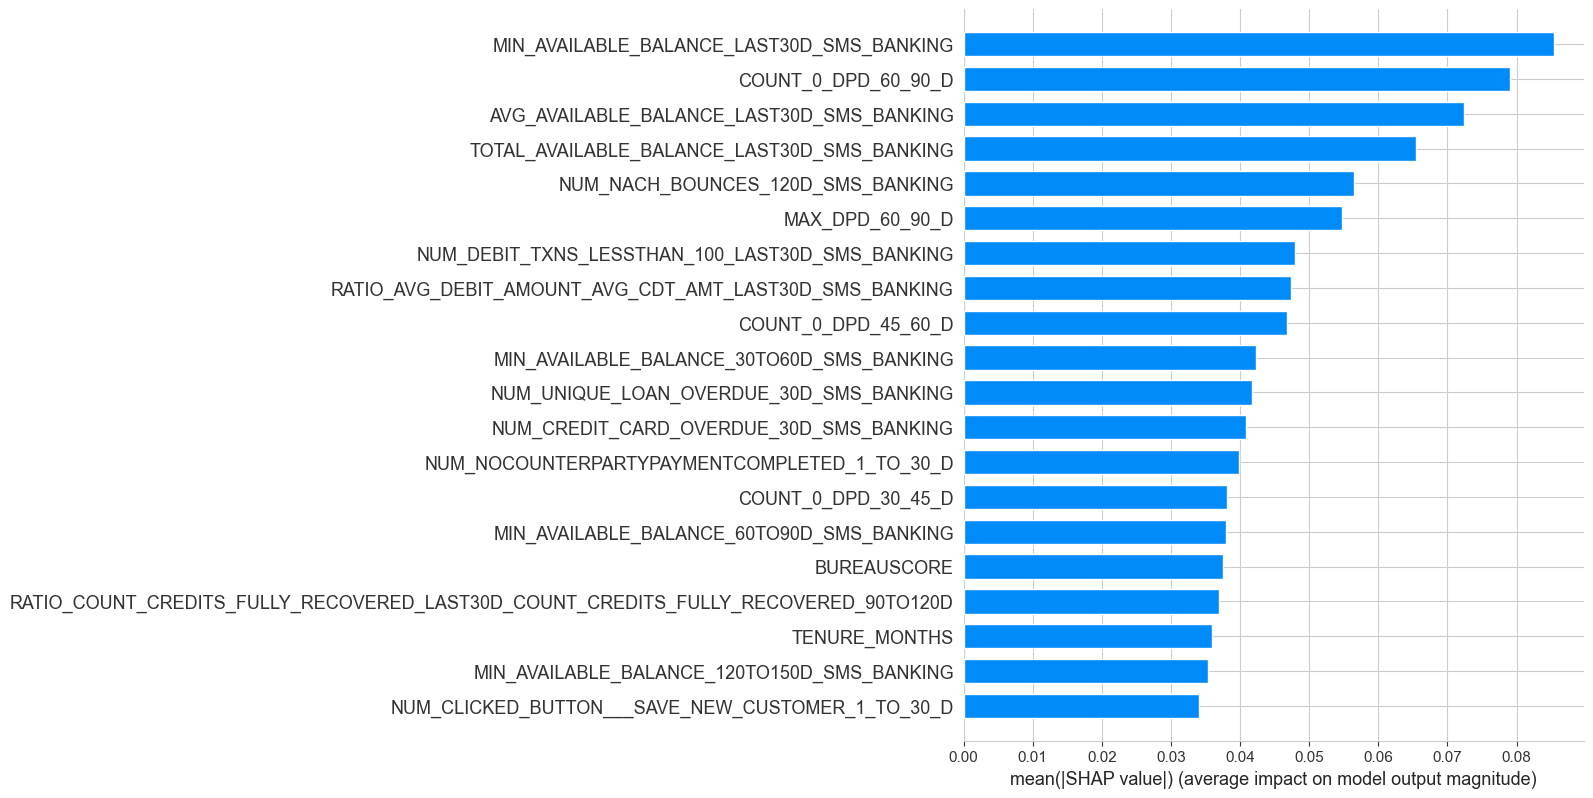

In [6]:
shap.summary_plot(shap_values, X_shap_sample, max_display=20, plot_type="bar")

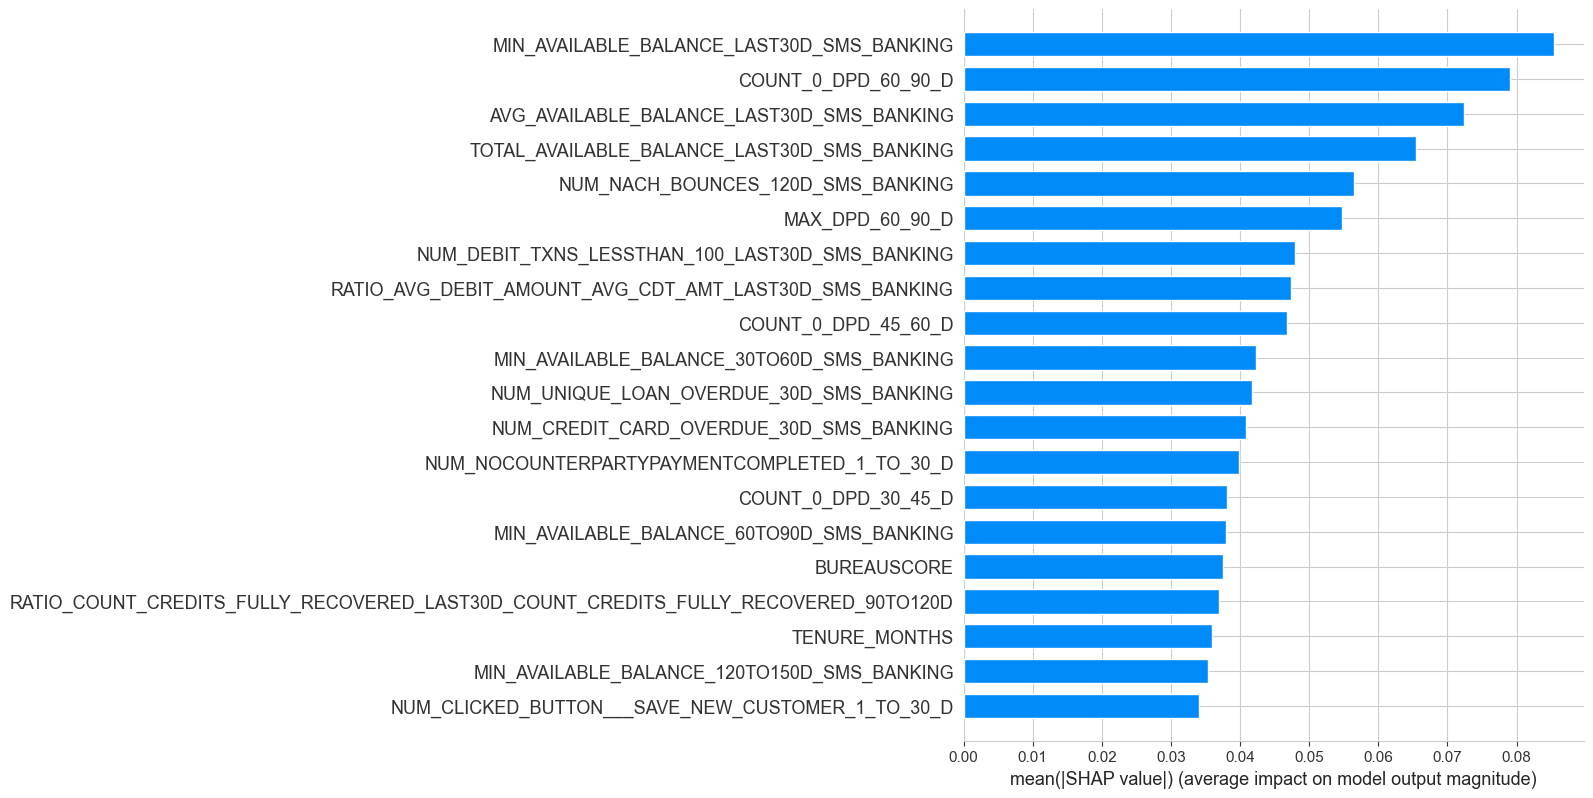

In [7]:
# Feature Importance Bar (Mean Absolute SHAP)
plt.figure()
shap.summary_plot(shap_values, X_shap_sample, plot_type="bar", max_display=20)


Top 10 Extreme Predictions:
HIGH #1: Index=104610, Predicted Probability=0.9619


<Figure size 1400x300 with 0 Axes>

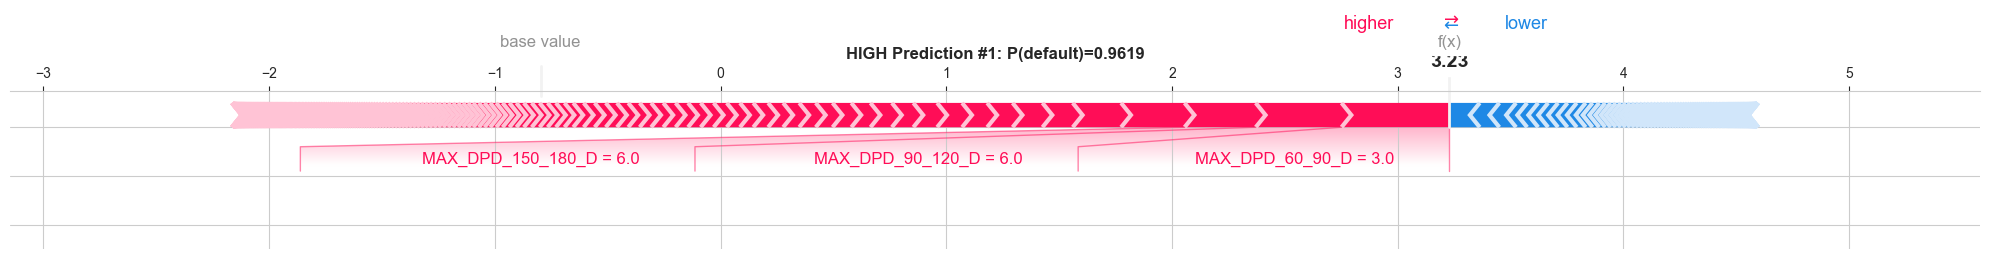

HIGH #2: Index=125252, Predicted Probability=0.9597


<Figure size 1400x300 with 0 Axes>

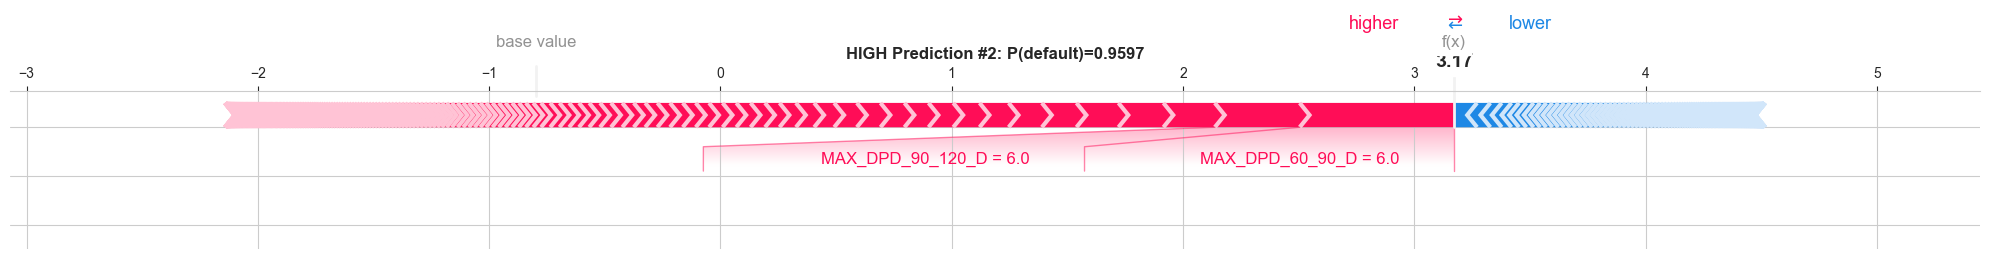

HIGH #3: Index=60249, Predicted Probability=0.9597


<Figure size 1400x300 with 0 Axes>

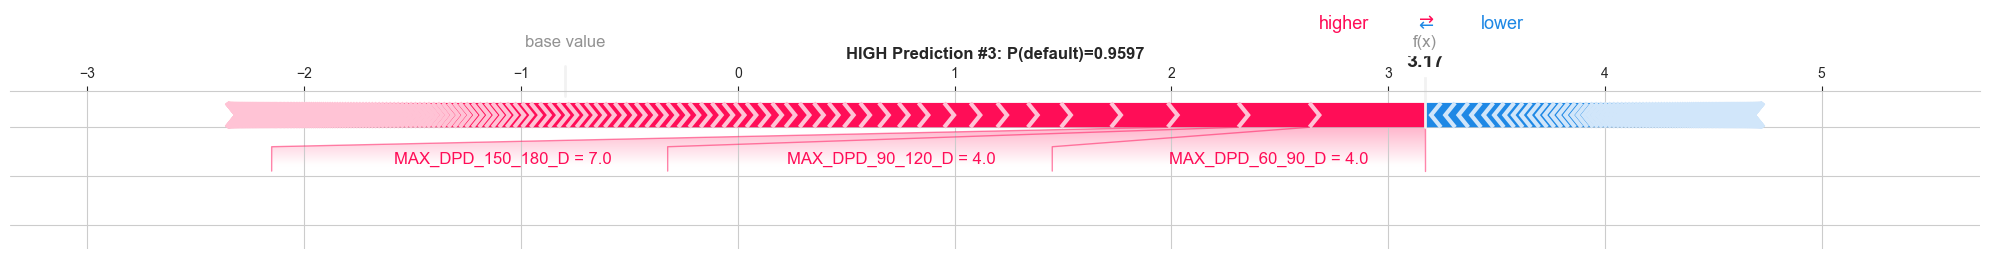

HIGH #4: Index=10819, Predicted Probability=0.9580


<Figure size 1400x300 with 0 Axes>

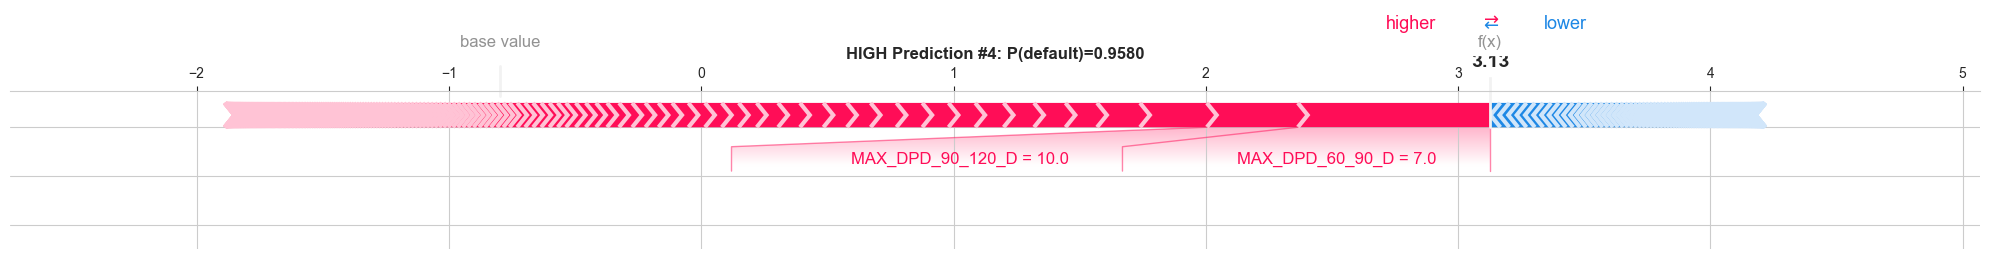

HIGH #5: Index=37087, Predicted Probability=0.9558


<Figure size 1400x300 with 0 Axes>

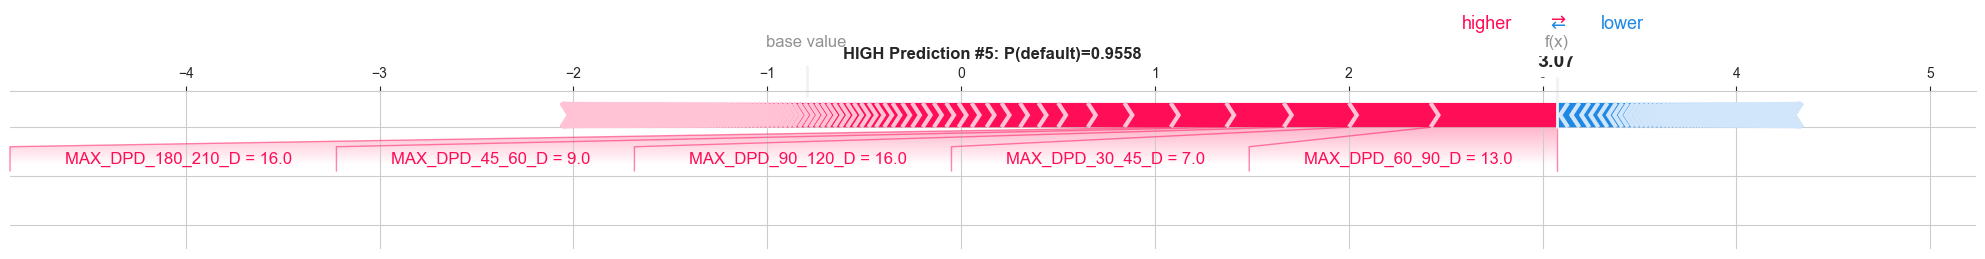

LOW #1: Index=113626, Predicted Probability=0.0115


<Figure size 1400x300 with 0 Axes>

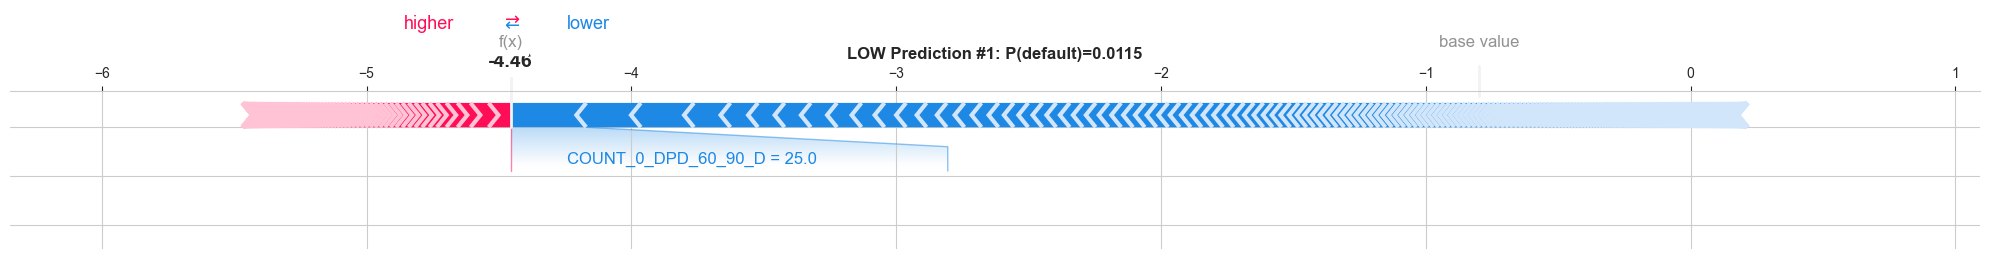

LOW #2: Index=4013, Predicted Probability=0.0151


<Figure size 1400x300 with 0 Axes>

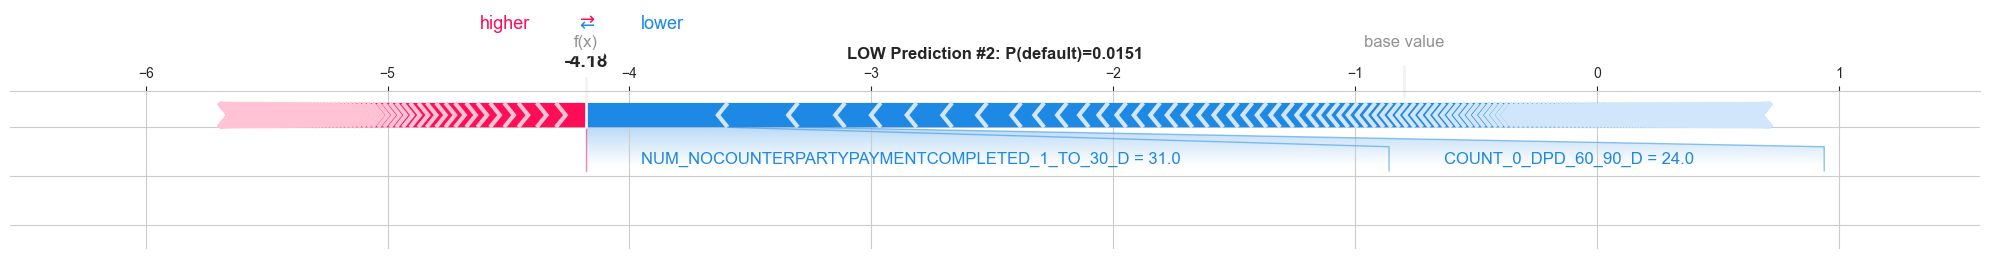

LOW #3: Index=84253, Predicted Probability=0.0151


<Figure size 1400x300 with 0 Axes>

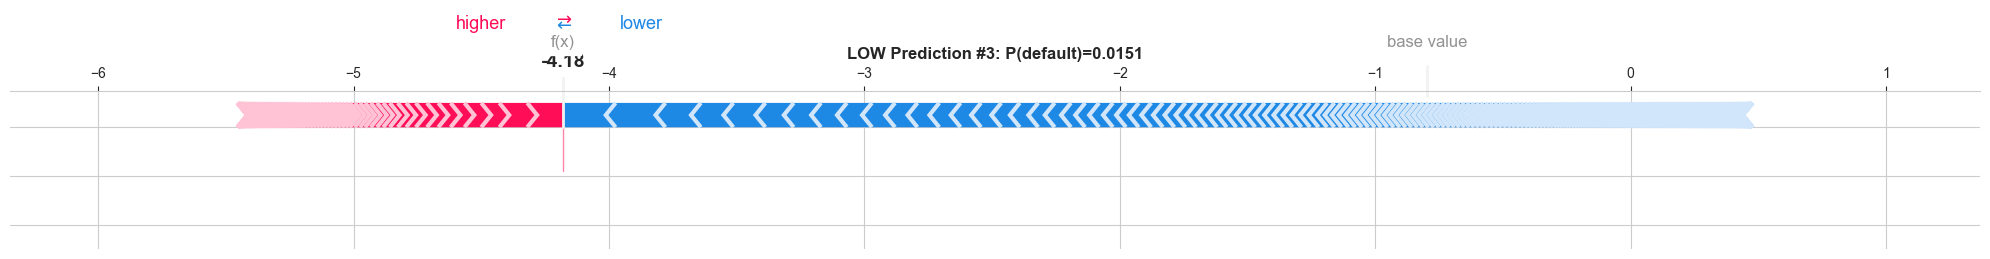

LOW #4: Index=56326, Predicted Probability=0.0158


<Figure size 1400x300 with 0 Axes>

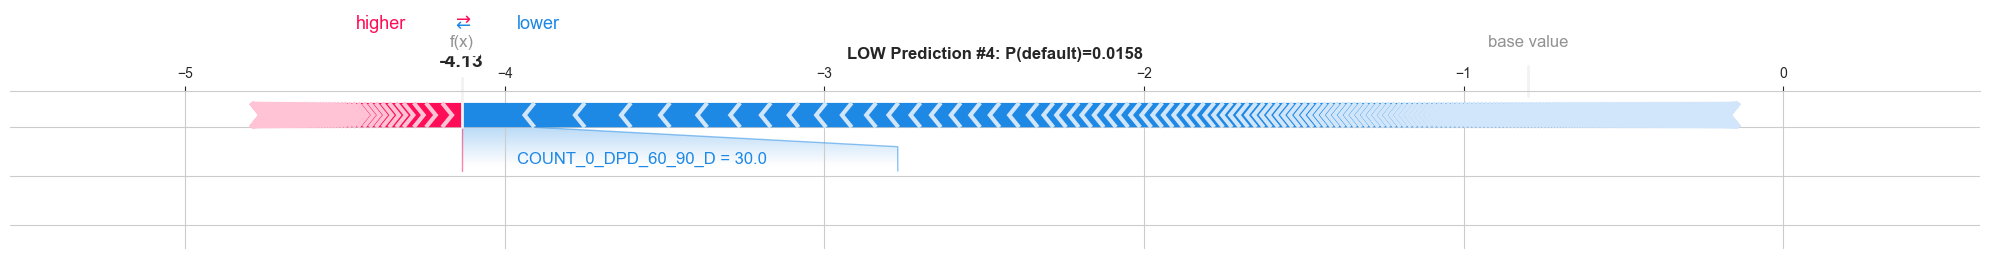

LOW #5: Index=75602, Predicted Probability=0.0164


<Figure size 1400x300 with 0 Axes>

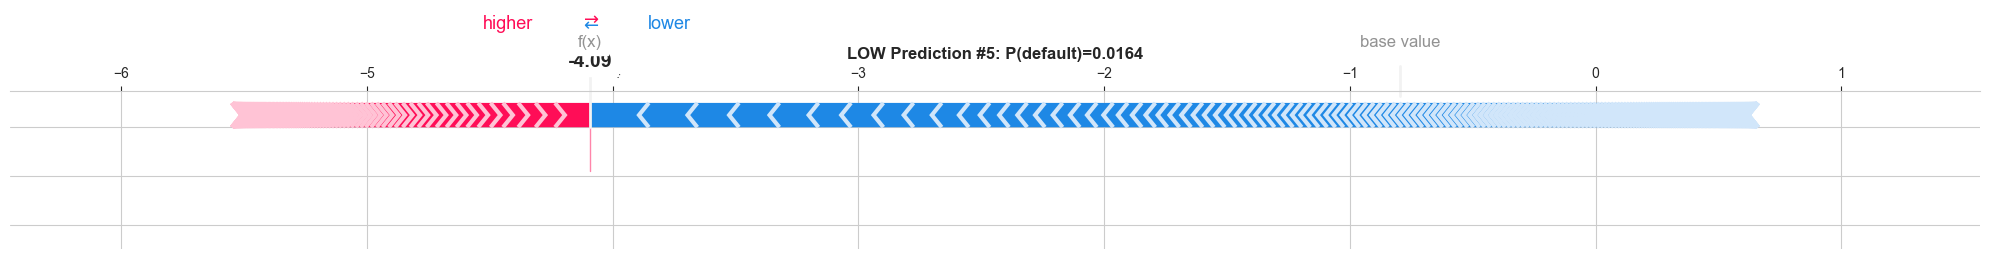

In [8]:
# Top 10 Individual Force Plots - Extreme Predictions
y_pred_proba = model.predict_proba(X_shap_sample)[:, 1]

# Get 5 highest and 5 lowest predictions
top_indices = np.argsort(y_pred_proba)[-5:][::-1]
bottom_indices = np.argsort(y_pred_proba)[:5]
extreme_indices = np.concatenate([top_indices, bottom_indices])

print("Top 10 Extreme Predictions:")
print("=" * 80)
for i, idx in enumerate(extreme_indices):
    pred = y_pred_proba[idx]
    label = "HIGH" if i < 5 else "LOW"
    print(f"{label} #{i%5 + 1}: Index={X_shap_sample.index[idx]}, Predicted Probability={pred:.4f}")
    
    plt.figure(figsize=(14, 3))
    shap.force_plot(
        explainer.expected_value, 
        shap_values[idx], 
        X_shap_sample.iloc[idx],
        matplotlib=True,
        show=False
    )
    plt.title(f"{label} Prediction #{i%5 + 1}: P(default)={pred:.4f}", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()



Top 5 Features by Mean |SHAP|:
1. MIN_AVAILABLE_BALANCE_LAST30D_SMS_BANKING: 0.0854
2. COUNT_0_DPD_60_90_D: 0.0790
3. AVG_AVAILABLE_BALANCE_LAST30D_SMS_BANKING: 0.0723
4. TOTAL_AVAILABLE_BALANCE_LAST30D_SMS_BANKING: 0.0654
5. NUM_NACH_BOUNCES_120D_SMS_BANKING: 0.0565


<Figure size 1000x600 with 0 Axes>

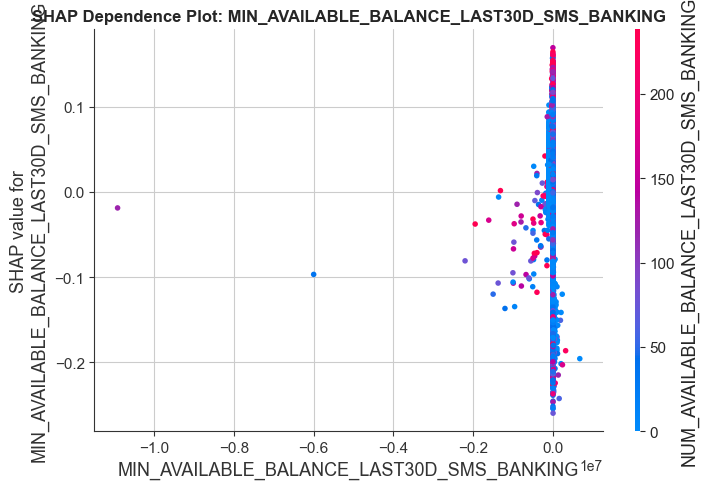

<Figure size 1000x600 with 0 Axes>

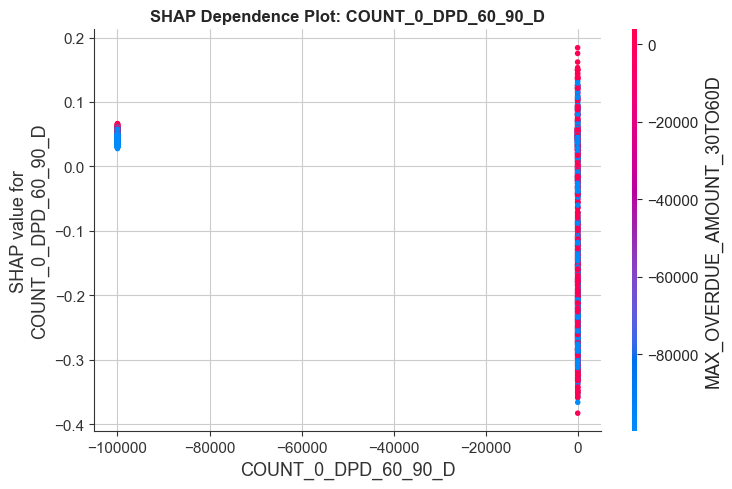

<Figure size 1000x600 with 0 Axes>

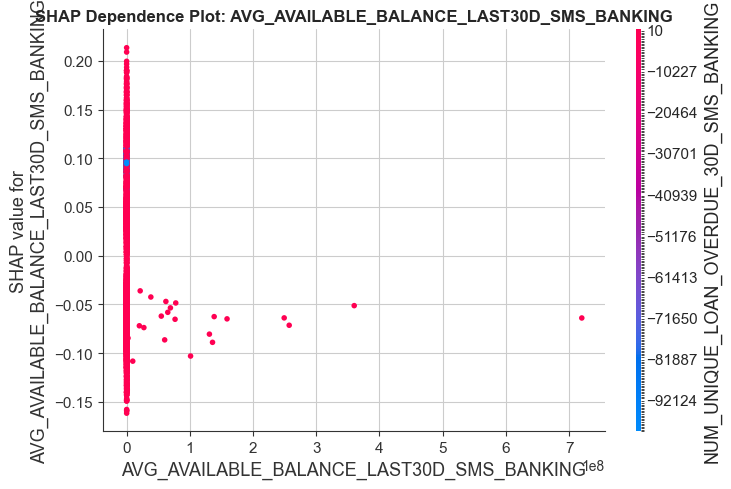

<Figure size 1000x600 with 0 Axes>

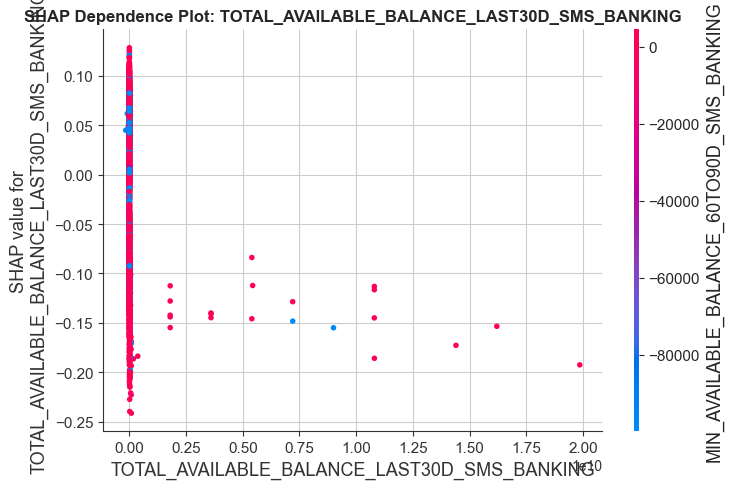

<Figure size 1000x600 with 0 Axes>

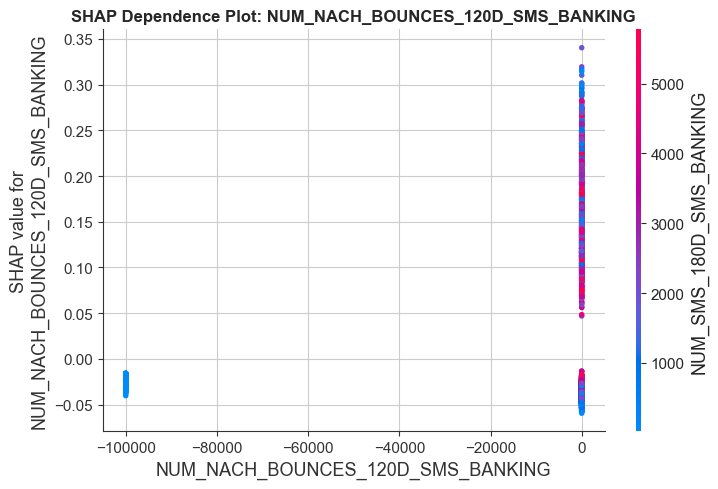

In [9]:
# Dependence Plots for Top 5 Features by Mean |SHAP|
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_5_indices = np.argsort(mean_abs_shap)[-5:][::-1]
top_5_features = [feature_names[i] for i in top_5_indices]

print(f"\nTop 5 Features by Mean |SHAP|:")
for rank, (idx, feat) in enumerate(zip(top_5_indices, top_5_features), 1):
    print(f"{rank}. {feat}: {mean_abs_shap[idx]:.4f}")

for feat_idx, feat_name in zip(top_5_indices, top_5_features):
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        feat_idx, 
        shap_values, 
        X_shap_sample, 
        show=False
    )
    plt.title(f"SHAP Dependence Plot: {feat_name}", fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()



Computing SHAP Interaction Values for Top 10 Features...
This may take several minutes...


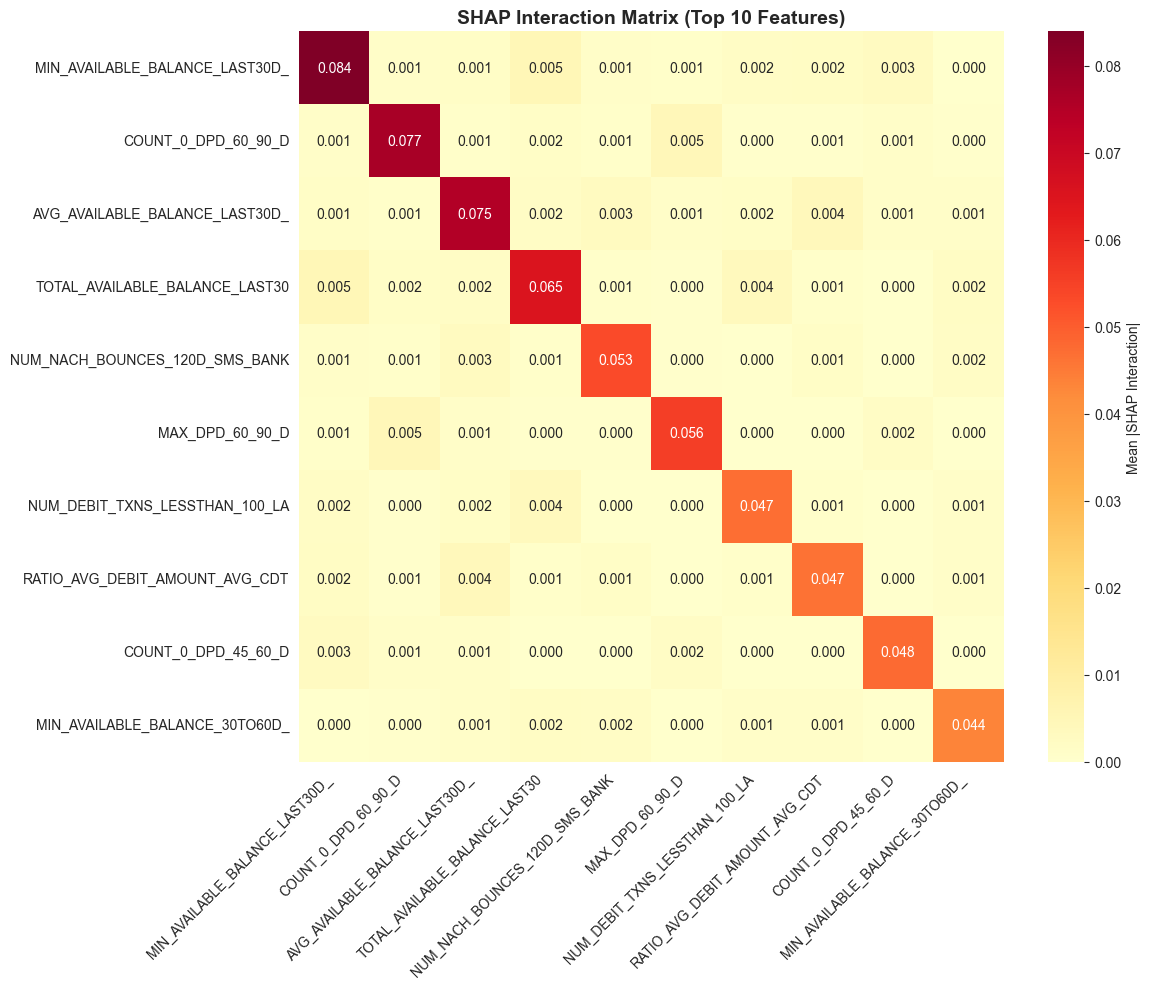

✓ Interaction analysis complete


In [10]:
# Interaction Matrix for Top 10 Features
top_10_indices = np.argsort(mean_abs_shap)[-10:][::-1]
top_10_features = [feature_names[i] for i in top_10_indices]

print("\n" + "=" * 80)
print("Computing SHAP Interaction Values for Top 10 Features...")
print("This may take several minutes...")

# Compute interaction values for smaller sample if needed
interaction_sample_size = min(1000, len(X_shap_sample))
X_interaction_sample = X_shap_sample.sample(n=interaction_sample_size, random_state=42)
shap_interaction_values = explainer.shap_interaction_values(X_interaction_sample)

# Extract interaction matrix for top 10 features
interaction_matrix = np.zeros((10, 10))
for i, idx_i in enumerate(top_10_indices):
    for j, idx_j in enumerate(top_10_indices):
        interaction_matrix[i, j] = np.abs(shap_interaction_values[:, idx_i, idx_j]).mean()

# Plot interaction heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    interaction_matrix,
    xticklabels=[f[:30] for f in top_10_features],
    yticklabels=[f[:30] for f in top_10_features],
    annot=True,
    fmt='.3f',
    cmap='YlOrRd',
    cbar_kws={'label': 'Mean |SHAP Interaction|'}
)
plt.title("SHAP Interaction Matrix (Top 10 Features)", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("✓ Interaction analysis complete")


In [11]:
# Top Feature Analysis Summary
print("\n" + "=" * 80)
print("TOP FEATURE CHARACTERISTICS")
print("=" * 80)

for rank, (feat_idx, feat_name) in enumerate(zip(top_5_indices, top_5_features), 1):
    feat_shap = shap_values[:, feat_idx]
    feat_values = X_shap_sample.iloc[:, feat_idx].values
    
    # Determine direction of effect
    correlation = np.corrcoef(feat_values, feat_shap)[0, 1]
    direction = "POSITIVE" if correlation > 0 else "NEGATIVE"
    
    # Magnitude range
    mag_min, mag_max = feat_shap.min(), feat_shap.max()
    mag_range = mag_max - mag_min
    
    # Top interaction partners (from interaction matrix)
    feat_position = np.where(top_10_indices == feat_idx)[0]
    if len(feat_position) > 0:
        interactions = interaction_matrix[feat_position[0], :]
        # Exclude self-interaction
        interactions[feat_position[0]] = 0
        top_3_partners_idx = np.argsort(interactions)[-3:][::-1]
        top_partners = [top_10_features[i] for i in top_3_partners_idx]
    else:
        top_partners = ["N/A"]
    
    print(f"\n{rank}. {feat_name}")
    print(f"   Direction: {direction} (correlation: {correlation:.3f})")
    print(f"   Magnitude Range: [{mag_min:.4f}, {mag_max:.4f}] (span: {mag_range:.4f})")
    print(f"   Top Interaction Partners: {', '.join(top_partners)}")



TOP FEATURE CHARACTERISTICS

1. MIN_AVAILABLE_BALANCE_LAST30D_SMS_BANKING
   Direction: POSITIVE (correlation: 0.000)
   Magnitude Range: [-0.2600, 0.1696] (span: 0.4296)
   Top Interaction Partners: TOTAL_AVAILABLE_BALANCE_LAST30D_SMS_BANKING, COUNT_0_DPD_45_60_D, RATIO_AVG_DEBIT_AMOUNT_AVG_CDT_AMT_LAST30D_SMS_BANKING

2. COUNT_0_DPD_60_90_D
   Direction: NEGATIVE (correlation: -0.733)
   Magnitude Range: [-0.3829, 0.1842] (span: 0.5670)
   Top Interaction Partners: MAX_DPD_60_90_D, TOTAL_AVAILABLE_BALANCE_LAST30D_SMS_BANKING, COUNT_0_DPD_45_60_D

3. AVG_AVAILABLE_BALANCE_LAST30D_SMS_BANKING
   Direction: NEGATIVE (correlation: -0.035)
   Magnitude Range: [-0.1616, 0.2134] (span: 0.3751)
   Top Interaction Partners: RATIO_AVG_DEBIT_AMOUNT_AVG_CDT_AMT_LAST30D_SMS_BANKING, NUM_NACH_BOUNCES_120D_SMS_BANKING, TOTAL_AVAILABLE_BALANCE_LAST30D_SMS_BANKING

4. TOTAL_AVAILABLE_BALANCE_LAST30D_SMS_BANKING
   Direction: NEGATIVE (correlation: -0.107)
   Magnitude Range: [-0.2415, 0.1285] (span:

## 3. Partial Dependence Analysis


Generating Partial Dependence Plots for Top 10 Features (by Gain)
Sample size: 1000
ICE curves: NO


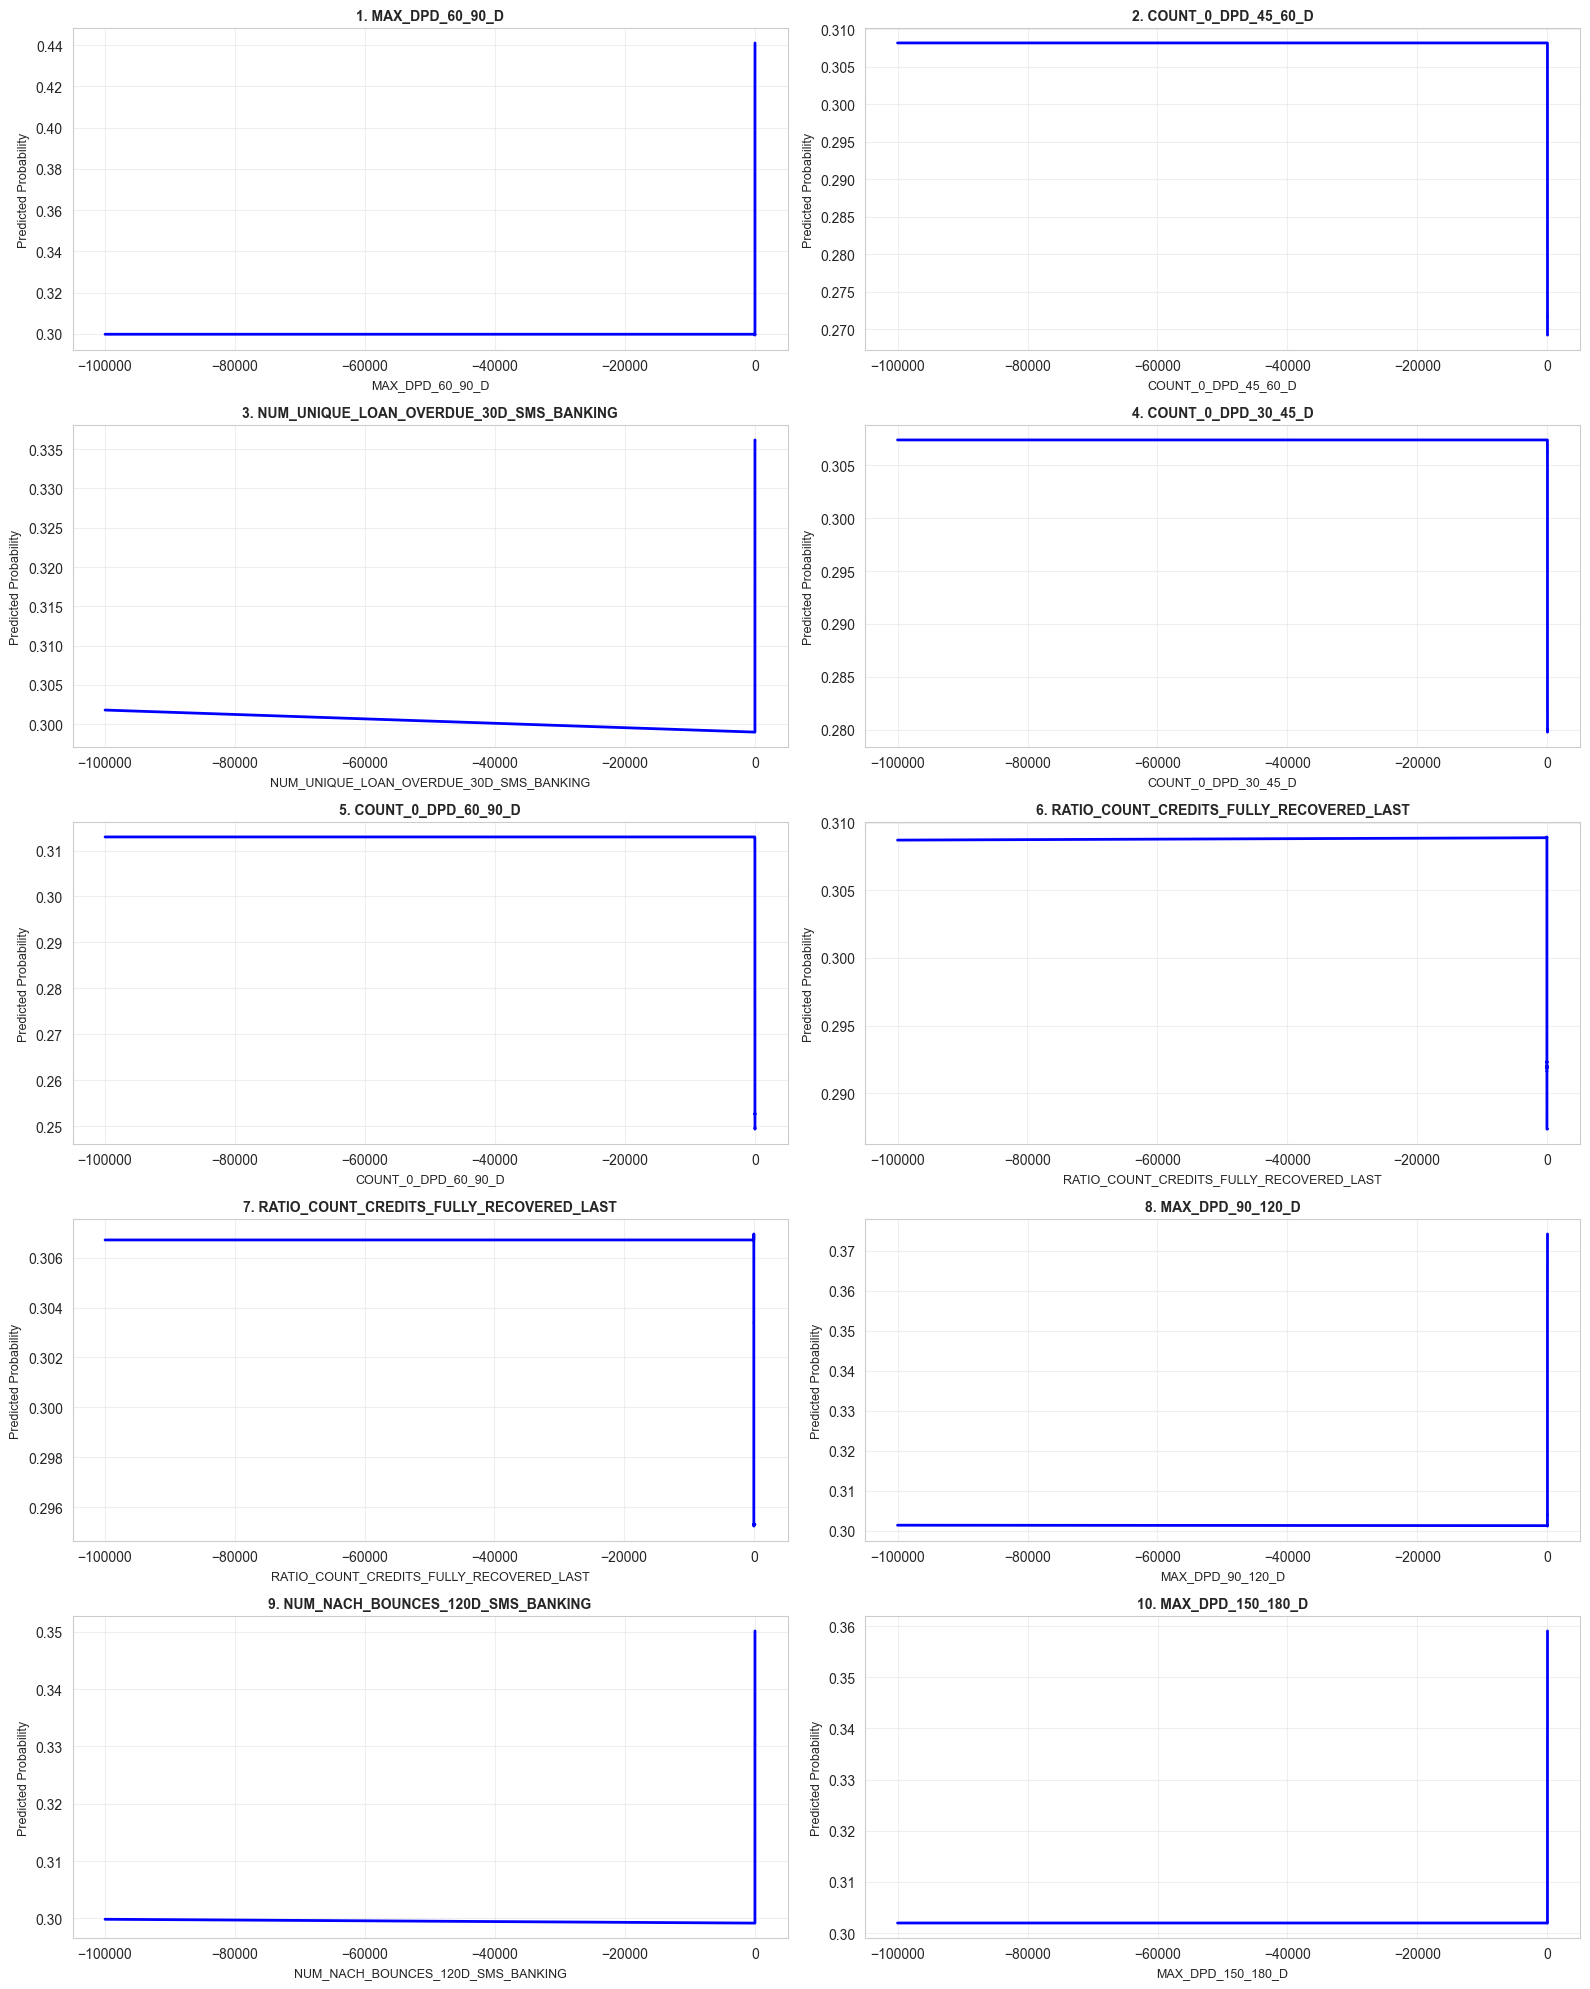

In [12]:
# Get top 10 features by gain
top_10_gain_features = importance_df.head(10)['Feature'].tolist()
top_10_gain_indices = [feature_names.index(f) for f in top_10_gain_features]

# Determine if we should add ICE curves
add_ice = len(X_train) < 1000
pd_sample_size = min(1000, len(X_train))
X_pd_sample = X_train.sample(n=pd_sample_size, random_state=42)

print(f"Generating Partial Dependence Plots for Top 10 Features (by Gain)")
print(f"Sample size: {pd_sample_size}")
print(f"ICE curves: {'YES' if add_ice else 'NO'}")
print("=" * 80)

# Create PD plots
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.ravel()

def compute_partial_dependence(model, X, feature_idx, grid_resolution=50):
    """Compute partial dependence for a feature"""
    X_temp = X.copy()
    feature_values = X.iloc[:, feature_idx].values
    
    # Create grid of values for the feature
    percentiles = np.linspace(0, 100, grid_resolution)
    grid_values = np.percentile(feature_values, percentiles)
    
    # Compute predictions for each grid value
    pd_values = []
    ice_lines = []
    
    for grid_val in grid_values:
        X_temp.iloc[:, feature_idx] = grid_val
        preds = model.predict_proba(X_temp)[:, 1]
        pd_values.append(preds.mean())
        if add_ice:
            ice_lines.append(preds)
    
    return grid_values, np.array(pd_values), np.array(ice_lines).T if add_ice else None

for i, (feat_idx, feat_name) in enumerate(zip(top_10_gain_indices, top_10_gain_features)):
    grid_vals, pd_vals, ice_vals = compute_partial_dependence(model, X_pd_sample, feat_idx)
    
    ax = axes[i]
    
    # Plot ICE curves if requested
    if add_ice and ice_vals is not None:
        for ice_line in ice_vals[::max(1, len(ice_vals)//50)]:  # Plot max 50 ICE curves
            ax.plot(grid_vals, ice_line, color='lightblue', alpha=0.3, linewidth=0.5)
    
    # Plot PD curve
    ax.plot(grid_vals, pd_vals, color='blue', linewidth=2, label='PD')
    ax.set_xlabel(feat_name[:40], fontsize=9)
    ax.set_ylabel('Predicted Probability', fontsize=9)
    ax.set_title(f"{i+1}. {feat_name[:40]}", fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)
    if add_ice:
        ax.legend(loc='best', fontsize=8)

plt.tight_layout()
plt.show()


In [13]:
# Analyze PD patterns: thresholds, plateaus, non-linearities
print("\n" + "=" * 80)
print("PARTIAL DEPENDENCE PATTERN ANALYSIS")
print("=" * 80)

for feat_idx, feat_name in zip(top_10_gain_indices, top_10_gain_features):
    # Compute PD
    grid_values, pd_values, _ = compute_partial_dependence(model, X_pd_sample, feat_idx)
    
    # Detect patterns
    pd_range = pd_values.max() - pd_values.min()
    
    # Detect thresholds (sharp changes)
    pd_diff = np.diff(pd_values)
    sharp_changes = np.where(np.abs(pd_diff) > 0.5 * pd_range / len(pd_values))[0]
    
    # Detect plateaus (flat regions)
    plateau_threshold = 0.05 * pd_range / len(pd_values)
    plateaus = np.where(np.abs(pd_diff) < plateau_threshold)[0]
    
    # Non-linearity score (variance of second derivative)
    if len(pd_values) > 2:
        second_deriv = np.diff(pd_diff)
        non_linearity = np.std(second_deriv)
    else:
        non_linearity = 0
    
    print(f"\n{feat_name[:50]}")
    print(f"  Range: {pd_values.min():.4f} to {pd_values.max():.4f} (span: {pd_range:.4f})")
    
    if len(sharp_changes) > 0:
        threshold_values = grid_values[sharp_changes][:3]  # Top 3
        print(f"  Thresholds detected at: {threshold_values}")
    else:
        print(f"  Thresholds: None detected")
    
    plateau_pct = len(plateaus) / len(pd_diff) * 100
    print(f"  Plateaus: {plateau_pct:.1f}% of range is relatively flat")
    
    if non_linearity > 0.01:
        print(f"  Non-linearity: HIGH (score: {non_linearity:.4f})")
    elif non_linearity > 0.001:
        print(f"  Non-linearity: MODERATE (score: {non_linearity:.4f})")
    else:
        print(f"  Non-linearity: LOW (score: {non_linearity:.4f})")



PARTIAL DEPENDENCE PATTERN ANALYSIS

MAX_DPD_60_90_D
  Range: 0.2994 to 0.4410 (span: 0.1416)
  Thresholds detected at: [1. 2. 3.]
  Plateaus: 89.8% of range is relatively flat
  Non-linearity: HIGH (score: 0.0185)

COUNT_0_DPD_45_60_D
  Range: 0.2692 to 0.3082 (span: 0.0389)
  Thresholds detected at: [0. 5. 7.]
  Plateaus: 83.7% of range is relatively flat
  Non-linearity: MODERATE (score: 0.0039)

NUM_UNIQUE_LOAN_OVERDUE_30D_SMS_BANKING
  Range: 0.2990 to 0.3362 (span: 0.0372)
  Thresholds detected at: [-99999.      0.]
  Plateaus: 93.9% of range is relatively flat
  Non-linearity: MODERATE (score: 0.0076)

COUNT_0_DPD_30_45_D
  Range: 0.2798 to 0.3074 (span: 0.0276)
  Thresholds detected at: [2. 7. 8.]
  Plateaus: 85.7% of range is relatively flat
  Non-linearity: MODERATE (score: 0.0042)

COUNT_0_DPD_60_90_D
  Range: 0.2493 to 0.3130 (span: 0.0636)
  Thresholds detected at: [ 9.         13.         15.12244898]
  Plateaus: 75.5% of range is relatively flat
  Non-linearity: MODERAT

## 4. Tree Structure Inspection


In [14]:
import json

booster = model.get_booster()

print("=" * 80)
print("TREE STRUCTURE INSPECTION (First 3 Trees)")
print("=" * 80)

# Get tree dump
trees_dump = booster.get_dump(dump_format='json')

for tree_idx in range(min(3, len(trees_dump))):
    tree_json = json.loads(trees_dump[tree_idx])
    
    print(f"\n{'='*80}")
    print(f"TREE {tree_idx}")
    print(f"{'='*80}")
    
    # Root split feature and threshold
    if 'split' in tree_json:
        root_feature = tree_json['split']
        root_threshold = tree_json.get('split_condition', 'N/A')
        print(f"Root Split: {root_feature} at threshold {root_threshold}")
    else:
        print(f"Root: Leaf node (no split)")
        continue
    
    # Count splits per feature and find max depth
    feature_split_counts = {}
    leaf_values = []
    
    def traverse_tree(node, depth=0):
        global max_depth_reached
        if depth > max_depth_reached:
            max_depth_reached = depth
            
        if 'split' in node:
            # Internal node
            feature = node['split']
            feature_split_counts[feature] = feature_split_counts.get(feature, 0) + 1
            
            if 'children' in node:
                for child in node['children']:
                    traverse_tree(child, depth + 1)
        elif 'leaf' in node:
            # Leaf node
            leaf_values.append(node['leaf'])
    
    max_depth_reached = 0
    traverse_tree(tree_json)
    
    # Count splits per feature
    print(f"\nSplits per Feature:")
    sorted_features = sorted(feature_split_counts.items(), key=lambda x: x[1], reverse=True)
    for feat, count in sorted_features[:10]:  # Top 10
        print(f"  {feat}: {count}")
    
    print(f"\nMax Depth Reached: {max_depth_reached}")
    
    # Top 3 leaf values by magnitude
    leaf_values_sorted = sorted(leaf_values, key=abs, reverse=True)
    print(f"\nTop 3 Leaf Values by Magnitude:")
    for i, val in enumerate(leaf_values_sorted[:3], 1):
        print(f"  {i}. {val:.6f}")


TREE STRUCTURE INSPECTION (First 3 Trees)

TREE 0
Root Split: MAX_DPD_60_90_D at threshold 3

Splits per Feature:
  MAX_DPD_60_90_D: 2
  MIN_AVAILABLE_BALANCE_LAST30D_SMS_BANKING: 2
  COUNT_0_DPD_120_150_D: 2
  COUNT_0_DPD_30_45_D: 1
  RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_FULLY_RECOVERED_90TO120D: 1
  MIN_CURRENT_BALANCE_ACTIVE_MAX: 1
  MAX_DPD_150_180_D: 1
  COUNT_2_DPD_90_120_D: 1
  COUNT_3_DPD_150_180_D: 1
  COUNT_0_DPD_60_90_D: 1

Max Depth Reached: 4

Top 3 Leaf Values by Magnitude:
  1. 0.114995
  2. 0.093714
  3. 0.082916

TREE 1
Root Split: MAX_DPD_60_90_D at threshold 3

Splits per Feature:
  NUM_UNIQUE_LOAN_OVERDUE_30D_SMS_BANKING: 2
  MAX_DPD_60_90_D: 1
  COUNT_0_DPD_30_45_D: 1
  RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_FULLY_RECOVERED_30TO60D: 1
  MAX_DPD_150_180_D: 1
  COUNT_2_DPD_90_120_D: 1
  COUNT_2_DPD_120_150_D: 1
  COUNT_0_DPD_60_90_D: 1
  COUNT_0_DPD_120_150_D: 1
  COUNT_6_DPD_60_90_D: 1

Max Depth Reached: 4

Top 3 Leaf Values 

## 5. Model Characterization


In [15]:
print("=" * 80)
print("MODEL CHARACTERIZATION")
print("=" * 80)

# Get model parameters
params = model.get_params()

# Total trees
total_trees = len(trees_dump)
print(f"\nTotal Trees: {total_trees}")

# Learning rate
learning_rate = params.get('learning_rate', params.get('eta', 'N/A'))
print(f"Learning Rate (eta): {learning_rate}")

# Max depth
max_depth = params.get('max_depth', 'N/A')
print(f"Max Depth: {max_depth}")

# Regularization parameters
reg_lambda = params.get('reg_lambda', params.get('lambda', 'N/A'))
reg_alpha = params.get('reg_alpha', params.get('alpha', 'N/A'))
min_child_weight = params.get('min_child_weight', 'N/A')

print(f"\nRegularization Parameters:")
print(f"  Lambda (L2): {reg_lambda}")
print(f"  Alpha (L1): {reg_alpha}")
print(f"  Min Child Weight: {min_child_weight}")

# Objective and evaluation metric
objective = params.get('objective', 'N/A')
eval_metric = params.get('eval_metric', 'N/A')

print(f"\nTraining Objective: {objective}")
print(f"Evaluation Metric: {eval_metric}")

# Additional parameters
print(f"\nAdditional Parameters:")
print(f"  Subsample: {params.get('subsample', 'N/A')}")
print(f"  Colsample by Tree: {params.get('colsample_bytree', 'N/A')}")
print(f"  Colsample by Level: {params.get('colsample_bylevel', 'N/A')}")
print(f"  Gamma (min_split_loss): {params.get('gamma', 'N/A')}")
print(f"  Scale Pos Weight: {params.get('scale_pos_weight', 'N/A')}")


MODEL CHARACTERIZATION

Total Trees: 1000
Learning Rate (eta): 0.05
Max Depth: 4

Regularization Parameters:
  Lambda (L2): 2
  Alpha (L1): 2
  Min Child Weight: None

Training Objective: binary:logistic
Evaluation Metric: None

Additional Parameters:
  Subsample: None
  Colsample by Tree: 0.9
  Colsample by Level: 0.9
  Gamma (min_split_loss): None
  Scale Pos Weight: None


## 6. Prediction Mechanism Summary


In [16]:
print("=" * 80)
print("PREDICTION MECHANISM SUMMARY")
print("=" * 80)

# Analyze feature importance concentration
top_10_gain_sum = importance_df.head(10)['Gain'].sum()
total_gain = importance_df['Gain'].sum()
concentration = (top_10_gain_sum / total_gain * 100) if total_gain > 0 else 0

# Analyze non-linearity from PD analysis
non_linear_features = 0
for feat_idx in top_10_gain_indices:
    grid_values, pd_values, _ = compute_partial_dependence(model, X_pd_sample, feat_idx)
    if len(pd_values) > 2:
        second_deriv = np.diff(np.diff(pd_values))
        if np.std(second_deriv) > 0.01:
            non_linear_features += 1

non_linearity_ratio = non_linear_features / 10

# Analyze interaction strength
interaction_strength = interaction_matrix[np.triu_indices_from(interaction_matrix, k=1)].mean()

# Model complexity assessment
features_used = len(importance_df[importance_df['Gain'] > 0])
trees_per_feature_used = total_trees / features_used if features_used > 0 else 0

print("\n" + "=" * 80)
print("SUMMARY:")
print("=" * 80)

print(f"\n📊 FEATURE DRIVERS:")
print(f"The model's predictions are primarily driven by {features_used} features out of {len(feature_names)} total. "
      f"The top 10 features account for {concentration:.1f}% of total gain, with {top_10_gain_features[0]} "
      f"being the most influential. Feature importance is {'highly concentrated' if concentration > 70 else 'moderately distributed' if concentration > 50 else 'broadly distributed'} "
      f"across the feature space.")

print(f"\n📈 LINEAR VS NON-LINEAR PATTERNS:")
print(f"The model exhibits {'predominantly non-linear' if non_linearity_ratio > 0.6 else 'mixed linear and non-linear' if non_linearity_ratio > 0.3 else 'mostly linear'} "
      f"relationships, with {non_linear_features} out of top 10 features showing significant non-linear patterns in their partial dependence plots. "
      f"This {'suggests complex' if non_linearity_ratio > 0.5 else 'indicates moderate'} decision boundaries that capture {'intricate' if non_linearity_ratio > 0.6 else 'nuanced'} "
      f"relationships between features and the target variable.")

print(f"\n🔗 INTERACTION EFFECTS:")
print(f"Feature interactions show {'strong' if interaction_strength > 0.1 else 'moderate' if interaction_strength > 0.05 else 'weak'} "
      f"presence (mean interaction magnitude: {interaction_strength:.4f}), indicating that predictions are "
      f"{'heavily influenced' if interaction_strength > 0.1 else 'partially influenced' if interaction_strength > 0.05 else 'minimally influenced'} "
      f"by joint effects between features rather than purely additive contributions.")

print(f"\n⚙️  MODEL COMPLEXITY ASSESSMENT:")
if trees_per_feature_used > 10 and total_trees > 500:
    complexity_assessment = "potentially overfit"
    recommendation = "The high tree count and deep trees may capture training noise. Consider pruning or early stopping."
elif trees_per_feature_used < 2 and total_trees < 100:
    complexity_assessment = "potentially underfit"
    recommendation = "The model may lack capacity to capture complex patterns. Consider increasing tree count."
else:
    complexity_assessment = "appropriately balanced"
    recommendation = "Model complexity appears suitable for the problem."

print(f"With {total_trees} trees, maximum depth of {max_depth}, and learning rate of {learning_rate}, "
      f"the model appears {complexity_assessment}. {recommendation}")

print("\n" + "=" * 80)


PREDICTION MECHANISM SUMMARY

SUMMARY:

📊 FEATURE DRIVERS:
The model's predictions are primarily driven by 358 features out of 360 total. The top 10 features account for 19.5% of total gain, with MAX_DPD_60_90_D being the most influential. Feature importance is broadly distributed across the feature space.

📈 LINEAR VS NON-LINEAR PATTERNS:
The model exhibits mostly linear relationships, with 1 out of top 10 features showing significant non-linear patterns in their partial dependence plots. This indicates moderate decision boundaries that capture nuanced relationships between features and the target variable.

🔗 INTERACTION EFFECTS:
Feature interactions show weak presence (mean interaction magnitude: 0.0013), indicating that predictions are minimally influenced by joint effects between features rather than purely additive contributions.

⚙️  MODEL COMPLEXITY ASSESSMENT:
With 1000 trees, maximum depth of 4, and learning rate of 0.05, the model appears appropriately balanced. Model comple

## 7. Performance Analysis - Identifying Poor Performance Populations


In [17]:
# Generate predictions for train and test
print("Generating predictions for train and test sets...")
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
y_test_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = (y_train_pred_proba >= 0.5).astype(int)
y_test_pred = (y_test_pred_proba >= 0.5).astype(int)

print("✓ Predictions generated")

# Calculate performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("\n" + "=" * 80)
print("OVERALL PERFORMANCE METRICS")
print("=" * 80)

train_metrics = {
    'Accuracy': accuracy_score(y_train, y_train_pred),
    'Precision': precision_score(y_train, y_train_pred, zero_division=0),
    'Recall': recall_score(y_train, y_train_pred, zero_division=0),
    'F1': f1_score(y_train, y_train_pred, zero_division=0),
    'AUC-ROC': roc_auc_score(y_train, y_train_pred_proba)
}

test_metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred, zero_division=0),
    'Recall': recall_score(y_test, y_test_pred, zero_division=0),
    'F1': f1_score(y_test, y_test_pred, zero_division=0),
    'AUC-ROC': roc_auc_score(y_test, y_test_pred_proba)
}

print("\nTRAIN SET:")
for metric, value in train_metrics.items():
    print(f"  {metric:12s}: {value:.4f}")

print("\nTEST SET:")
for metric, value in test_metrics.items():
    print(f"  {metric:12s}: {value:.4f}")

print("\n" + "=" * 80)


Generating predictions for train and test sets...
✓ Predictions generated

OVERALL PERFORMANCE METRICS

TRAIN SET:
  Accuracy    : 0.7568
  Precision   : 0.7344
  Recall      : 0.3449
  F1          : 0.4694
  AUC-ROC     : 0.8009

TEST SET:
  Accuracy    : 0.7563
  Precision   : 0.5550
  Recall      : 0.3016
  F1          : 0.3908
  AUC-ROC     : 0.7180



In [18]:
# Calculate prediction errors for train and test
# For classification: error = 1 if prediction is wrong, 0 if correct
train_errors = (y_train != y_train_pred).astype(int)
test_errors = (y_test != y_test_pred).astype(int)

# Calculate absolute residuals (difference between predicted probability and actual)
train_residuals = np.abs(y_train_pred_proba - y_train)
test_residuals = np.abs(y_test_pred_proba - y_test)

# Create dataframes with features, actuals, predictions, and errors
train_analysis_df = X_train.copy()
train_analysis_df['actual'] = y_train.values
train_analysis_df['predicted_proba'] = y_train_pred_proba
train_analysis_df['predicted'] = y_train_pred
train_analysis_df['error'] = train_errors
train_analysis_df['residual'] = train_residuals
train_analysis_df['dataset'] = 'train'

test_analysis_df = X_test.copy()
test_analysis_df['actual'] = y_test.values
test_analysis_df['predicted_proba'] = y_test_pred_proba
test_analysis_df['predicted'] = y_test_pred
test_analysis_df['error'] = test_errors
test_analysis_df['residual'] = test_residuals
test_analysis_df['dataset'] = 'test'

print(f"Train errors: {train_errors.sum():,} / {len(train_errors):,} ({train_errors.mean()*100:.2f}%)")
print(f"Test errors: {test_errors.sum():,} / {len(test_errors):,} ({test_errors.mean()*100:.2f}%)")
print(f"\nMean train residual: {train_residuals.mean():.4f}")
print(f"Mean test residual: {test_residuals.mean():.4f}")


Train errors: 29,964 / 123,208 (24.32%)
Test errors: 1,116 / 4,580 (24.37%)

Mean train residual: 0.3456
Mean test residual: 0.3596


### 7.1 Decision Tree Analysis to Find Poor Performance Populations


In [19]:
# Combine train and test for analysis
combined_df = pd.concat([train_analysis_df, test_analysis_df], ignore_index=True)

# Fit a decision tree to predict high error (residual above median)
# This helps us find which feature combinations lead to poor predictions
high_error_threshold = combined_df['residual'].quantile(0.75)  # Top 25% worst predictions
combined_df['high_error'] = (combined_df['residual'] > high_error_threshold).astype(int)

print("=" * 80)
print("DECISION TREE TO IDENTIFY POOR PERFORMANCE POPULATIONS")
print("=" * 80)
print(f"\nHigh error threshold (75th percentile): {high_error_threshold:.4f}")
print(f"Samples with high error: {combined_df['high_error'].sum():,} / {len(combined_df):,} ({combined_df['high_error'].mean()*100:.2f}%)")

# Fit decision tree to understand which populations have high errors
dt_error = DecisionTreeClassifier(
    max_depth=5, 
    min_samples_leaf=100,
    min_samples_split=200,
    random_state=42
)

# Use only top features for interpretability
top_30_features = importance_df.head(30)['Feature'].tolist()
X_combined = combined_df[top_30_features]
y_high_error = combined_df['high_error']

dt_error.fit(X_combined, y_high_error)
print(f"\n✓ Decision tree fitted (max_depth={dt_error.max_depth})")
print(f"Train accuracy: {dt_error.score(X_combined, y_high_error):.4f}")


DECISION TREE TO IDENTIFY POOR PERFORMANCE POPULATIONS

High error threshold (75th percentile): 0.4930
Samples with high error: 31,947 / 127,788 (25.00%)

✓ Decision tree fitted (max_depth=5)
Train accuracy: 0.7500


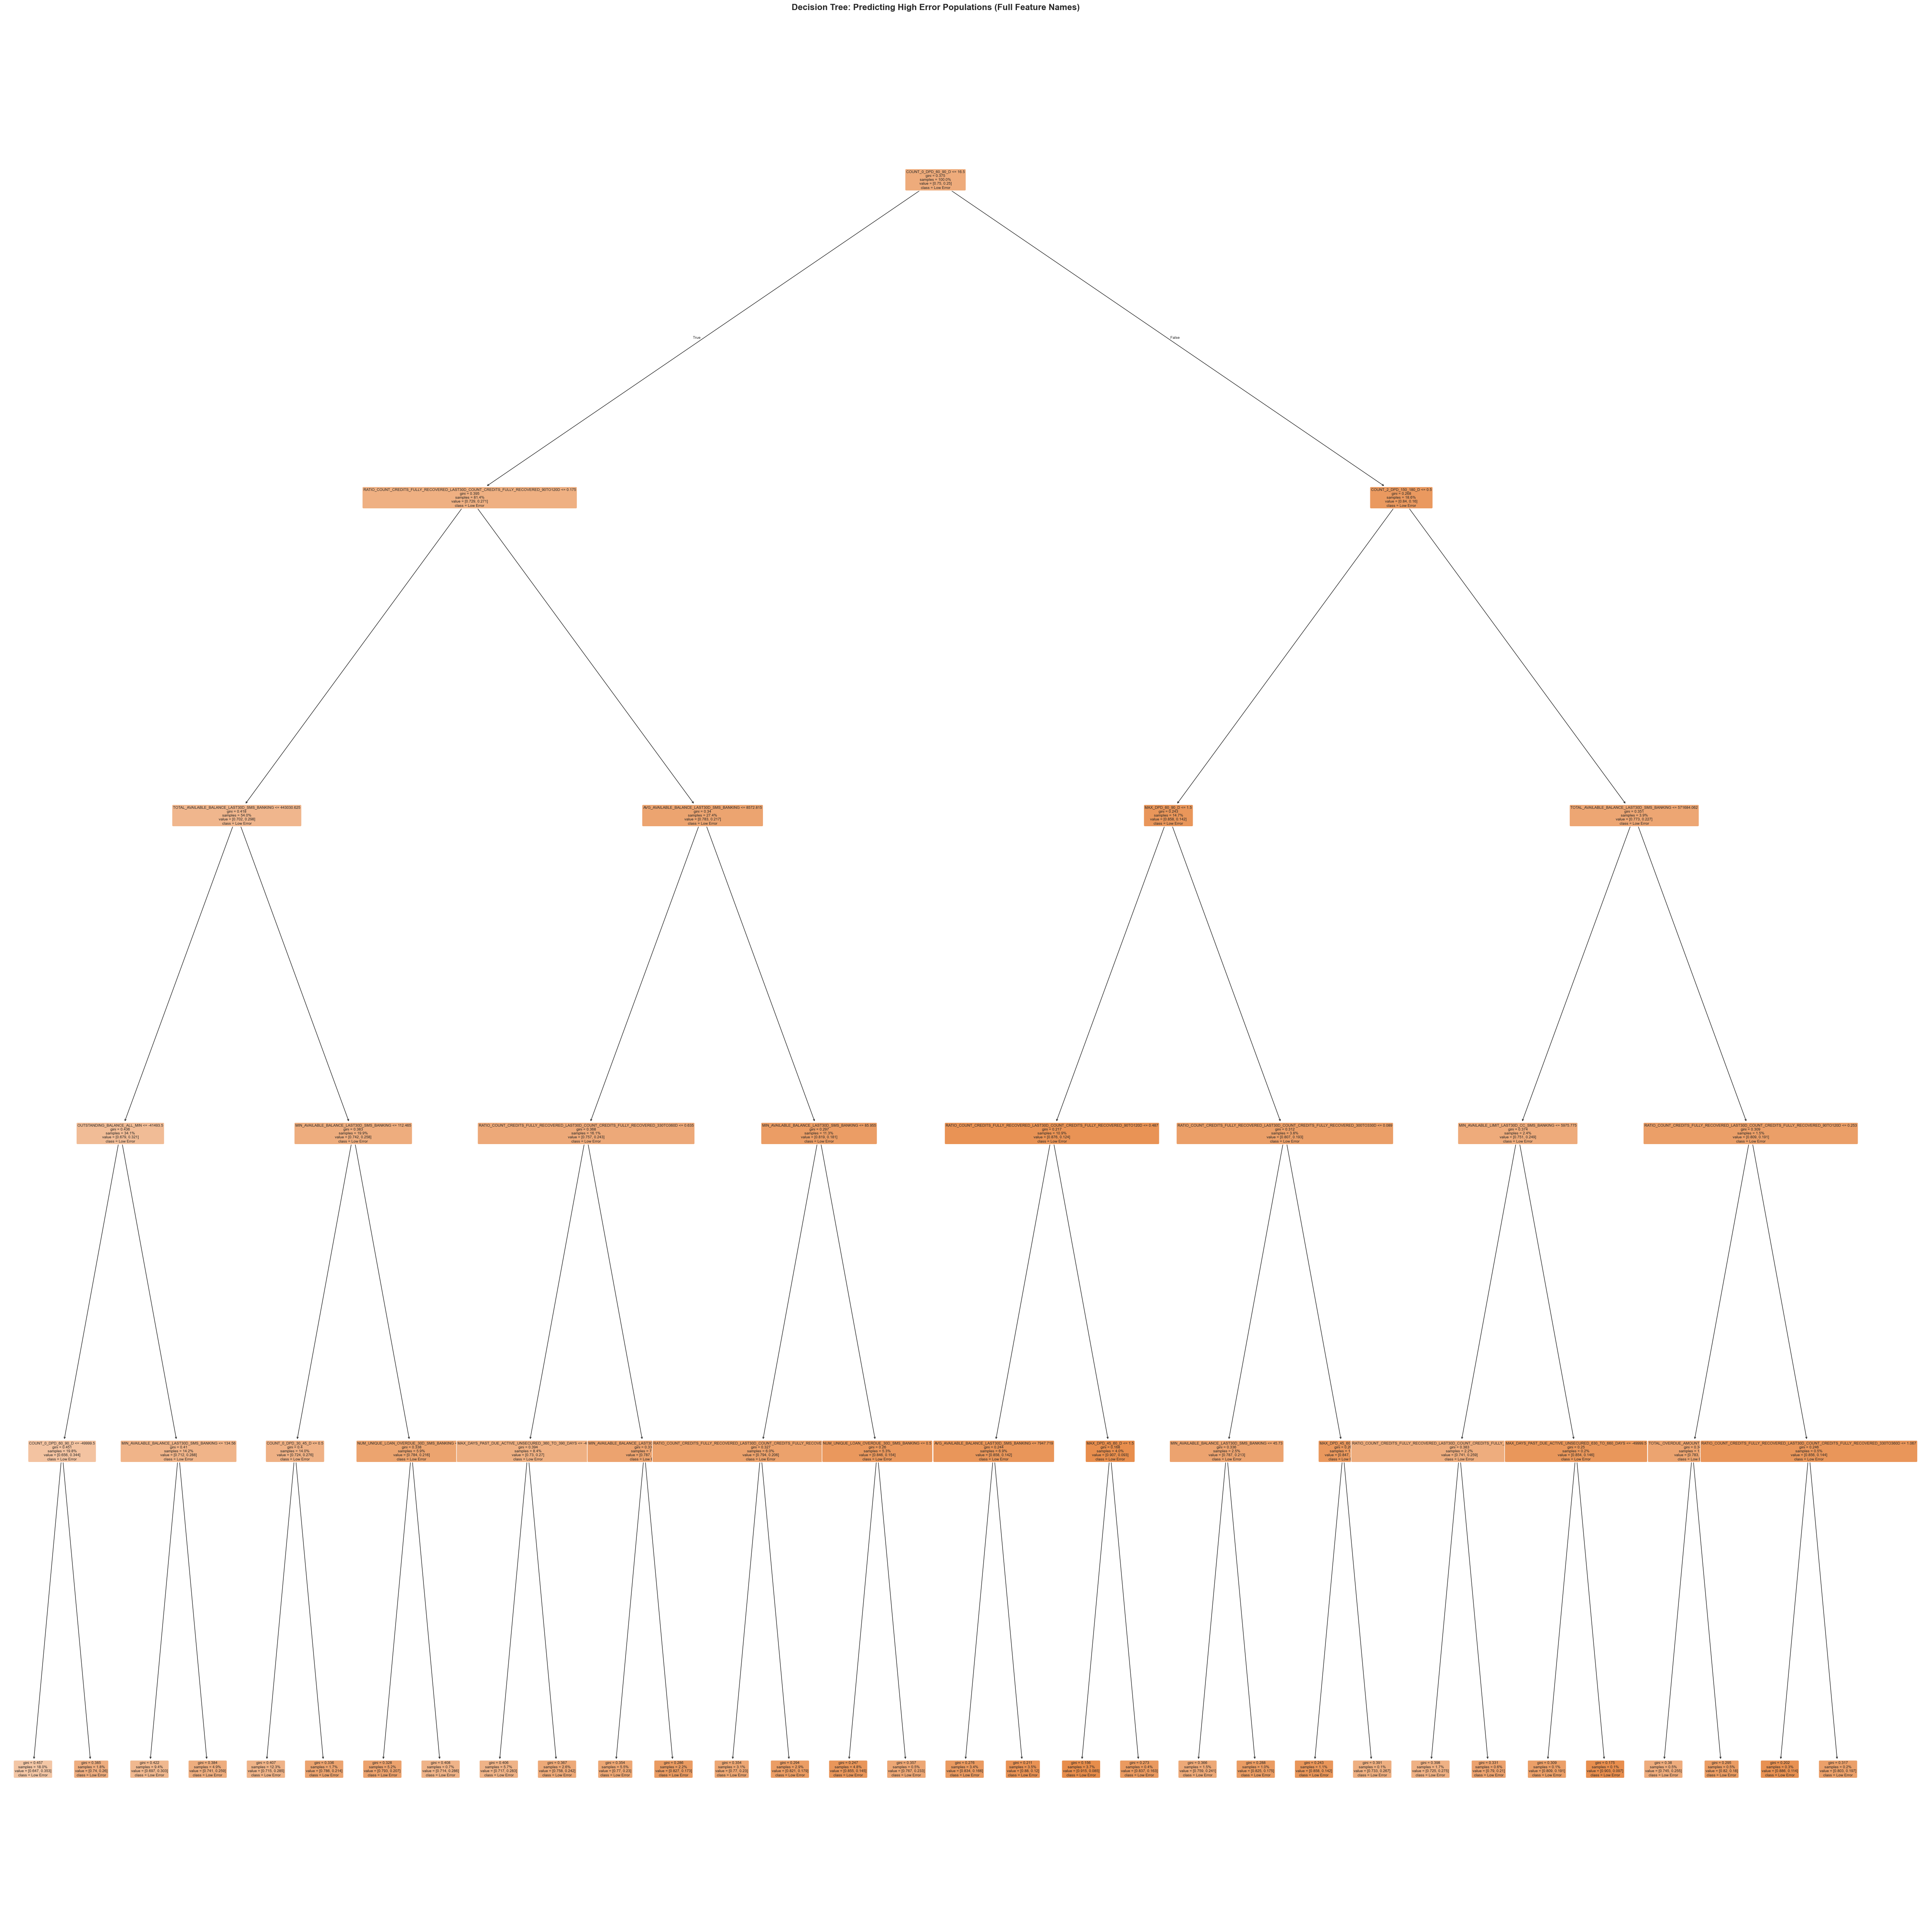


✓ Decision tree visualization with full feature names displayed


In [20]:
# Visualize the error prediction tree with FULL FEATURE NAMES
plt.figure(figsize=(50,50))
plot_tree(
    dt_error,
    feature_names=top_30_features,  # Full feature names without truncation
    class_names=['Low Error', 'High Error'],
    filled=True,
    fontsize=7,
    rounded=True,
    proportion=True
)
plt.title("Decision Tree: Predicting High Error Populations (Full Feature Names)", 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n✓ Decision tree visualization with full feature names displayed")


In [21]:
# Extract leaf characteristics from the error prediction tree
tree_struct = dt_error.tree_

def extract_leaf_info_with_empirical_bounds(tree, data_df, node_id=0, depth=0, mask=None, feature_names=None):
    """Recursively extract information about leaf nodes with empirical boundaries"""
    if mask is None:
        mask = np.ones(len(data_df), dtype=bool)
    
    if tree.children_left[node_id] == tree.children_right[node_id]:  # Leaf node
        n_samples = tree.n_node_samples[node_id]
        value = tree.value[node_id][0]
        high_error_rate = value[1] / (value[0] + value[1]) if (value[0] + value[1]) > 0 else 0
        
        return [{
            'node_id': node_id,
            'depth': depth,
            'n_samples': n_samples,
            'n_high_error': int(value[1]),
            'high_error_rate': high_error_rate,
            'mask': mask.copy()
        }]
    else:
        # Internal node
        feature = feature_names[tree.feature[node_id]]
        threshold = tree.threshold[node_id]
        
        # Split the mask
        left_mask = mask & (data_df[feature].values <= threshold)
        right_mask = mask & (data_df[feature].values > threshold)
        
        left_leaves = extract_leaf_info_with_empirical_bounds(
            tree, data_df, tree.children_left[node_id], depth + 1, left_mask, feature_names
        )
        right_leaves = extract_leaf_info_with_empirical_bounds(
            tree, data_df, tree.children_right[node_id], depth + 1, right_mask, feature_names
        )
        
        return left_leaves + right_leaves

def get_empirical_conditions(data_df, mask, feature_names):
    """Get empirical boundaries for features in a leaf"""
    leaf_data = data_df[mask]
    conditions = []
    
    for feature in feature_names:
        min_val = leaf_data[feature].min()
        max_val = leaf_data[feature].max()
        conditions.append(f"{feature}: [{min_val:.4f}, {max_val:.4f}]")
    
    return conditions

leaf_info = extract_leaf_info_with_empirical_bounds(
    tree_struct, 
    combined_df[top_30_features], 
    feature_names=top_30_features
)
leaf_df = pd.DataFrame(leaf_info)
leaf_df = leaf_df.sort_values('high_error_rate', ascending=False)

print("\n" + "=" * 120)
print("TOP 10 LEAF NODES WITH HIGHEST ERROR RATES (Poor Performance Populations)")
print("=" * 120)

for idx, row in leaf_df.head(10).iterrows():
    print(f"\n{'='*120}")
    print(f"LEAF {row['node_id']} (Rank: {leaf_df.index.get_loc(idx) + 1})")
    print(f"{'='*120}")
    print(f"Samples: {row['n_samples']:,} ({row['n_samples']/len(combined_df)*100:.2f}% of total)")
    print(f"High Error Count: {row['n_high_error']:,}")
    print(f"High Error Rate: {row['high_error_rate']*100:.2f}%")
    print(f"\nEmpirical Feature Boundaries (min, max):")
    conditions = get_empirical_conditions(combined_df[top_30_features], row['mask'], top_30_features)
    for i, cond in enumerate(conditions, 1):
        print(f"  {i}. {cond}")



TOP 10 LEAF NODES WITH HIGHEST ERROR RATES (Poor Performance Populations)

LEAF 5 (Rank: 1)
Samples: 23,023 (18.02% of total)
High Error Count: 0
High Error Rate: 35.26%

Empirical Feature Boundaries (min, max):
  1. MAX_DPD_60_90_D: [-99999.0000, -99999.0000]
  2. COUNT_0_DPD_45_60_D: [-99999.0000, -99999.0000]
  3. NUM_UNIQUE_LOAN_OVERDUE_30D_SMS_BANKING: [-99999.0000, 75.0000]
  4. COUNT_0_DPD_30_45_D: [-99999.0000, -99999.0000]
  5. COUNT_0_DPD_60_90_D: [-99999.0000, -99999.0000]
  6. RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_FULLY_RECOVERED_90TO120D: [-99999.0000, 0.1746]
  7. RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_FULLY_RECOVERED_300TO330D: [-99999.0000, 543.0000]
  8. MAX_DPD_90_120_D: [-99999.0000, -99999.0000]
  9. NUM_NACH_BOUNCES_120D_SMS_BANKING: [-99999.0000, 23.0000]
  10. MAX_DPD_150_180_D: [-99999.0000, -99999.0000]
  11. COUNT_3_DPD_60_90_D: [-99999.0000, -99999.0000]
  12. RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_FU

### 7.2 Analyzing Performance in Poor Populations Across Train and Test


In [22]:
# For each poor-performing leaf, analyze performance on train vs test
print("\n" + "=" * 120)
print("DETAILED ANALYSIS: POOR PERFORMANCE POPULATIONS ON TRAIN VS TEST")
print("=" * 120)

# Get leaf assignments for all samples
leaf_assignments = dt_error.apply(X_combined)
combined_df['leaf_id'] = leaf_assignments

# Analyze top 5 worst performing leaves
for idx, row in leaf_df.head(5).iterrows():
    leaf_id = row['node_id']
    
    # Filter samples in this leaf
    leaf_mask = combined_df['leaf_id'] == leaf_id
    leaf_samples = combined_df[leaf_mask]
    
    # Separate by train/test
    train_leaf = leaf_samples[leaf_samples['dataset'] == 'train']
    test_leaf = leaf_samples[leaf_samples['dataset'] == 'test']
    
    print(f"\n{'='*120}")
    print(f"LEAF {leaf_id} - Population Characteristics")
    print(f"{'='*120}")
    
    # Overall stats
    print(f"\nTotal Samples: {len(leaf_samples):,}")
    print(f"  Train: {len(train_leaf):,} ({len(train_leaf)/len(leaf_samples)*100:.1f}%)")
    print(f"  Test: {len(test_leaf):,} ({len(test_leaf)/len(leaf_samples)*100:.1f}%)")
    
    # Performance metrics for this population
    print(f"\nPerformance Metrics:")
    print(f"  {'Dataset':<10} {'Error Rate':<15} {'Mean Residual':<20} {'Actual Class 1%':<20} {'Pred Class 1%'}")
    print(f"  {'-'*10} {'-'*15} {'-'*20} {'-'*20} {'-'*15}")
    
    if len(train_leaf) > 0:
        train_error_rate = train_leaf['error'].mean()
        train_mean_residual = train_leaf['residual'].mean()
        train_actual_class1 = train_leaf['actual'].mean()
        train_pred_class1 = train_leaf['predicted'].mean()
        print(f"  {'Train':<10} {train_error_rate*100:>6.2f}%        {train_mean_residual:>8.4f}           {train_actual_class1*100:>7.2f}%            {train_pred_class1*100:>6.2f}%")
    
    if len(test_leaf) > 0:
        test_error_rate = test_leaf['error'].mean()
        test_mean_residual = test_leaf['residual'].mean()
        test_actual_class1 = test_leaf['actual'].mean()
        test_pred_class1 = test_leaf['predicted'].mean()
        print(f"  {'Test':<10} {test_error_rate*100:>6.2f}%        {test_mean_residual:>8.4f}           {test_actual_class1*100:>7.2f}%            {test_pred_class1*100:>6.2f}%")
    
    # Feature statistics for this population
    print(f"\nKey Feature Statistics (Top 5 Important Features):")
    print(f"  {'Feature':<50} {'Mean':<15} {'Median':<15} {'Std'}")
    print(f"  {'-'*50} {'-'*15} {'-'*15} {'-'*15}")
    
    for feat in importance_df.head(5)['Feature'].tolist():
        if feat in leaf_samples.columns:
            feat_mean = leaf_samples[feat].mean()
            feat_median = leaf_samples[feat].median()
            feat_std = leaf_samples[feat].std()
            print(f"  {feat[:48]:<50} {feat_mean:>12.4f}    {feat_median:>12.4f}    {feat_std:>12.4f}")
    
    # Show the conditions for this leaf
    print(f"\nPopulation Definition (Empirical Feature Boundaries):")
    conditions = get_empirical_conditions(combined_df[top_30_features], row['mask'], top_30_features)
    for i, cond in enumerate(conditions, 1):
        print(f"  {i}. {cond}")



DETAILED ANALYSIS: POOR PERFORMANCE POPULATIONS ON TRAIN VS TEST

LEAF 5 - Population Characteristics

Total Samples: 23,023
  Train: 22,298 (96.9%)
  Test: 725 (3.1%)

Performance Metrics:
  Dataset    Error Rate      Mean Residual        Actual Class 1%      Pred Class 1%
  ---------- --------------- -------------------- -------------------- ---------------
  Train       33.68%          0.4381             42.49%             25.99%
  Test        31.86%          0.4448             34.90%             21.24%

Key Feature Statistics (Top 5 Important Features):
  Feature                                            Mean            Median          Std
  -------------------------------------------------- --------------- --------------- ---------------
  MAX_DPD_60_90_D                                     -99999.0000     -99999.0000          0.0000
  COUNT_0_DPD_45_60_D                                 -99999.0000     -99999.0000          0.0000
  NUM_UNIQUE_LOAN_OVERDUE_30D_SMS_BANKING        

### 7.3 Visualization: Error Rates by Population Segments


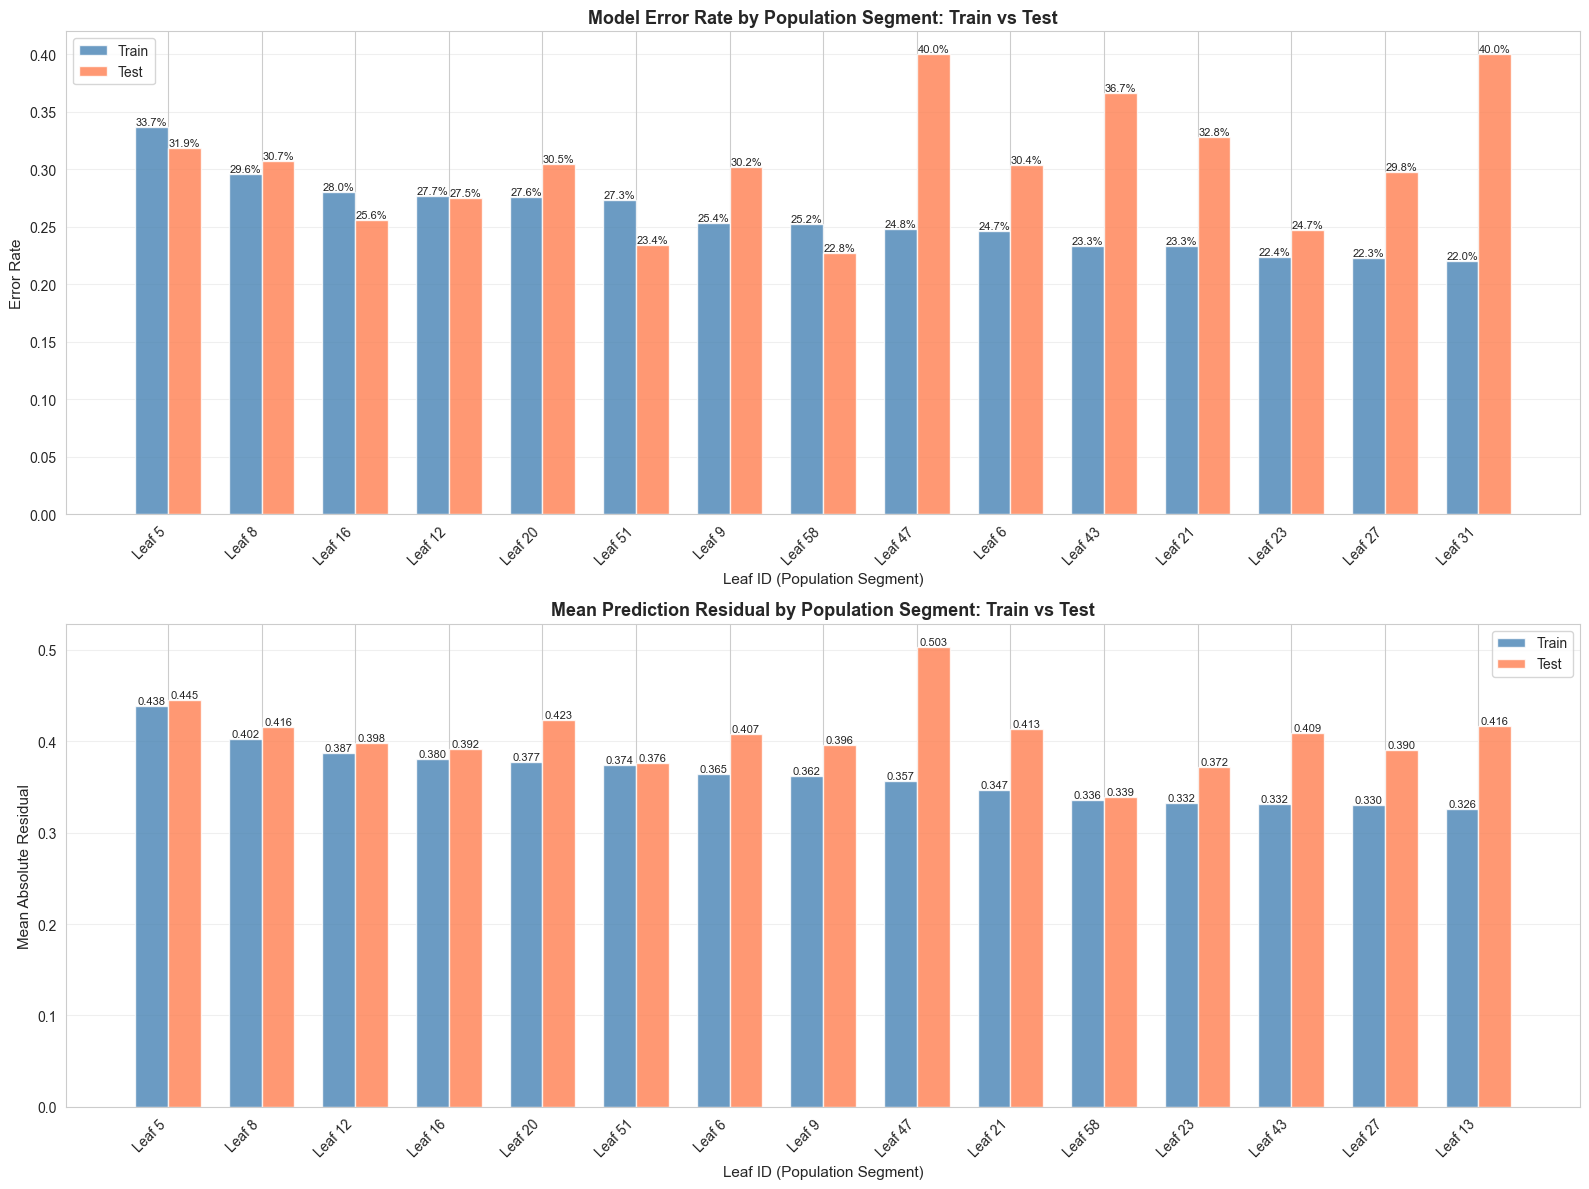

In [23]:
# Create visualization comparing error rates across leaves for train vs test
leaf_error_summary = []

for leaf_id in leaf_df['node_id'].unique():
    leaf_mask = combined_df['leaf_id'] == leaf_id
    leaf_samples = combined_df[leaf_mask]
    
    train_leaf = leaf_samples[leaf_samples['dataset'] == 'train']
    test_leaf = leaf_samples[leaf_samples['dataset'] == 'test']
    
    if len(train_leaf) > 0:
        leaf_error_summary.append({
            'leaf_id': leaf_id,
            'dataset': 'Train',
            'error_rate': train_leaf['error'].mean(),
            'n_samples': len(train_leaf),
            'mean_residual': train_leaf['residual'].mean()
        })
    
    if len(test_leaf) > 0:
        leaf_error_summary.append({
            'leaf_id': leaf_id,
            'dataset': 'Test',
            'error_rate': test_leaf['error'].mean(),
            'n_samples': len(test_leaf),
            'mean_residual': test_leaf['residual'].mean()
        })

leaf_error_df = pd.DataFrame(leaf_error_summary)

# Plot error rates by leaf and dataset
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Error rate comparison
ax1 = axes[0]
leaf_pivot = leaf_error_df.pivot(index='leaf_id', columns='dataset', values='error_rate')
leaf_pivot = leaf_pivot.sort_values('Train', ascending=False).head(15)

x = np.arange(len(leaf_pivot))
width = 0.35

bars1 = ax1.bar(x - width/2, leaf_pivot['Train'], width, label='Train', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x + width/2, leaf_pivot['Test'], width, label='Test', alpha=0.8, color='coral')

ax1.set_xlabel('Leaf ID (Population Segment)', fontsize=11)
ax1.set_ylabel('Error Rate', fontsize=11)
ax1.set_title('Model Error Rate by Population Segment: Train vs Test', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([f'Leaf {int(lid)}' for lid in leaf_pivot.index], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height*100:.1f}%', ha='center', va='bottom', fontsize=8)

# Plot 2: Mean residual comparison
ax2 = axes[1]
residual_pivot = leaf_error_df.pivot(index='leaf_id', columns='dataset', values='mean_residual')
residual_pivot = residual_pivot.sort_values('Train', ascending=False).head(15)

x2 = np.arange(len(residual_pivot))

bars3 = ax2.bar(x2 - width/2, residual_pivot['Train'], width, label='Train', alpha=0.8, color='steelblue')
bars4 = ax2.bar(x2 + width/2, residual_pivot['Test'], width, label='Test', alpha=0.8, color='coral')

ax2.set_xlabel('Leaf ID (Population Segment)', fontsize=11)
ax2.set_ylabel('Mean Absolute Residual', fontsize=11)
ax2.set_title('Mean Prediction Residual by Population Segment: Train vs Test', fontsize=13, fontweight='bold')
ax2.set_xticks(x2)
ax2.set_xticklabels([f'Leaf {int(lid)}' for lid in residual_pivot.index], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


### 7.4 Summary: Populations Where Model Performs Poorly on BOTH Train and Test


In [24]:
# Identify leaves where BOTH train and test have high error rates
print("=" * 120)
print("POPULATIONS WITH CONSISTENTLY POOR PERFORMANCE (High Error on BOTH Train AND Test)")
print("=" * 120)

# Calculate combined error metrics for each leaf
leaf_combined_errors = []

for leaf_id in leaf_df['node_id'].unique():
    leaf_mask = combined_df['leaf_id'] == leaf_id
    leaf_samples = combined_df[leaf_mask]
    
    train_leaf = leaf_samples[leaf_samples['dataset'] == 'train']
    test_leaf = leaf_samples[leaf_samples['dataset'] == 'test']
    
    # Only consider leaves with sufficient samples in both train and test
    if len(train_leaf) >= 50 and len(test_leaf) >= 10:
        train_error = train_leaf['error'].mean()
        test_error = test_leaf['error'].mean()
        
        # Consider as "consistently poor" if both train and test have high error
        # High error defined as above 75th percentile
        error_threshold = 0.30  # 30% error rate threshold
        
        if train_error >= error_threshold and test_error >= error_threshold:
            # Get leaf info
            leaf_info_row = leaf_df[leaf_df['node_id'] == leaf_id].iloc[0]
            
            leaf_combined_errors.append({
                'leaf_id': leaf_id,
                'train_error': train_error,
                'test_error': test_error,
                'avg_error': (train_error + test_error) / 2,
                'train_samples': len(train_leaf),
                'test_samples': len(test_leaf),
                'train_residual': train_leaf['residual'].mean(),
                'test_residual': test_leaf['residual'].mean(),
                'mask': leaf_info_row['mask']
            })

poor_performance_df = pd.DataFrame(leaf_combined_errors)

if len(poor_performance_df) > 0:
    poor_performance_df = poor_performance_df.sort_values('avg_error', ascending=False)
    
    print(f"\nFound {len(poor_performance_df)} populations with consistently poor performance (≥30% error on both train and test)")
    print(f"\n{'='*120}\n")
    
    for idx, row in poor_performance_df.iterrows():
        print(f"{'='*120}")
        print(f"POPULATION {idx + 1}: Leaf {row['leaf_id']}")
        print(f"{'='*120}")
        
        print(f"\nError Rates:")
        print(f"  Train: {row['train_error']*100:.2f}% ({row['train_samples']:,} samples)")
        print(f"  Test:  {row['test_error']*100:.2f}% ({row['test_samples']:,} samples)")
        print(f"  Average: {row['avg_error']*100:.2f}%")
        
        print(f"\nMean Residuals:")
        print(f"  Train: {row['train_residual']:.4f}")
        print(f"  Test:  {row['test_residual']:.4f}")
        
        print(f"\nPopulation Characteristics (Empirical Feature Boundaries):")
        conditions = get_empirical_conditions(combined_df[top_30_features], row['mask'], top_30_features)
        for i, cond in enumerate(conditions, 1):
            print(f"  {i}. {cond}")
        
        # Get feature statistics for this population
        leaf_mask = combined_df['leaf_id'] == row['leaf_id']
        leaf_population = combined_df[leaf_mask]
        
        print(f"\nKey Feature Values (Top 10 Important Features):")
        print(f"  {'Feature':<50} {'Mean':>12} {'Median':>12} {'25th %':>12} {'75th %':>12}")
        print(f"  {'-'*50} {'-'*12} {'-'*12} {'-'*12} {'-'*12}")
        
        for feat in importance_df.head(10)['Feature'].tolist():
            if feat in leaf_population.columns:
                values = leaf_population[feat]
                print(f"  {feat[:48]:<50} {values.mean():>12.4f} {values.median():>12.4f} {values.quantile(0.25):>12.4f} {values.quantile(0.75):>12.4f}")
        
        print(f"\nActual vs Predicted Class Distribution:")
        train_pop = leaf_population[leaf_population['dataset'] == 'train']
        test_pop = leaf_population[leaf_population['dataset'] == 'test']
        
        print(f"  {'Dataset':<10} {'Actual Class 1':>18} {'Predicted Class 1':>20} {'Calibration Gap':>20}")
        print(f"  {'-'*10} {'-'*18} {'-'*20} {'-'*20}")
        
        if len(train_pop) > 0:
            train_actual = train_pop['actual'].mean()
            train_pred = train_pop['predicted'].mean()
            train_gap = train_pred - train_actual
            print(f"  {'Train':<10} {train_actual*100:>15.2f}%   {train_pred*100:>17.2f}%   {train_gap*100:>17.2f}%")
        
        if len(test_pop) > 0:
            test_actual = test_pop['actual'].mean()
            test_pred = test_pop['predicted'].mean()
            test_gap = test_pred - test_actual
            print(f"  {'Test':<10} {test_actual*100:>15.2f}%   {test_pred*100:>17.2f}%   {test_gap*100:>17.2f}%")
        
        print(f"\n")
    
else:
    print("\nNo populations found with consistently poor performance on both train and test sets.")
    print("Let's analyze populations with highest average error rates instead...")
    
    # Alternative: Show leaves with highest combined error
    for leaf_id in leaf_df.head(3)['node_id']:
        leaf_mask = combined_df['leaf_id'] == leaf_id
        leaf_samples = combined_df[leaf_mask]
        
        train_leaf = leaf_samples[leaf_samples['dataset'] == 'train']
        test_leaf = leaf_samples[leaf_samples['dataset'] == 'test']
        
        if len(train_leaf) > 0 and len(test_leaf) > 0:
            print(f"\n{'='*120}")
            print(f"LEAF {leaf_id}")
            print(f"{'='*120}")
            print(f"Train Error: {train_leaf['error'].mean()*100:.2f}% ({len(train_leaf):,} samples)")
            print(f"Test Error:  {test_leaf['error'].mean()*100:.2f}% ({len(test_leaf):,} samples)")

print("\n" + "=" * 120)


POPULATIONS WITH CONSISTENTLY POOR PERFORMANCE (High Error on BOTH Train AND Test)

Found 1 populations with consistently poor performance (≥30% error on both train and test)


POPULATION 1: Leaf 5

Error Rates:
  Train: 33.68% (22,298 samples)
  Test:  31.86% (725 samples)
  Average: 32.77%

Mean Residuals:
  Train: 0.4381
  Test:  0.4448

Population Characteristics (Empirical Feature Boundaries):
  1. MAX_DPD_60_90_D: [-99999.0000, -99999.0000]
  2. COUNT_0_DPD_45_60_D: [-99999.0000, -99999.0000]
  3. NUM_UNIQUE_LOAN_OVERDUE_30D_SMS_BANKING: [-99999.0000, 75.0000]
  4. COUNT_0_DPD_30_45_D: [-99999.0000, -99999.0000]
  5. COUNT_0_DPD_60_90_D: [-99999.0000, -99999.0000]
  6. RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_FULLY_RECOVERED_90TO120D: [-99999.0000, 0.1746]
  7. RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_FULLY_RECOVERED_300TO330D: [-99999.0000, 543.0000]
  8. MAX_DPD_90_120_D: [-99999.0000, -99999.0000]
  9. NUM_NACH_BOUNCES_120D_SMS_BANKING: [-9999

### 7.5 Feature Importance for Error Prediction


FEATURES THAT BEST PREDICT WHERE MODEL PERFORMS POORLY

These features identify populations where the model makes high errors:

Rank   Feature                                                      Importance     
------ ------------------------------------------------------------ ---------------
1      COUNT_0_DPD_60_90_D                                          0.361861       
2      RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_   0.225551       
3      TOTAL_AVAILABLE_BALANCE_LAST30D_SMS_BANKING                  0.093788       
4      MIN_AVAILABLE_BALANCE_LAST30D_SMS_BANKING                    0.066201       
5      AVG_AVAILABLE_BALANCE_LAST30D_SMS_BANKING                    0.052175       
6      OUTSTANDING_BALANCE_ALL_MIN                                  0.047316       
7      COUNT_2_DPD_150_180_D                                        0.040960       
8      RATIO_COUNT_CREDITS_FULLY_RECOVERED_LAST30D_COUNT_CREDITS_   0.025011       
9      MAX_DPD_60_90_D          

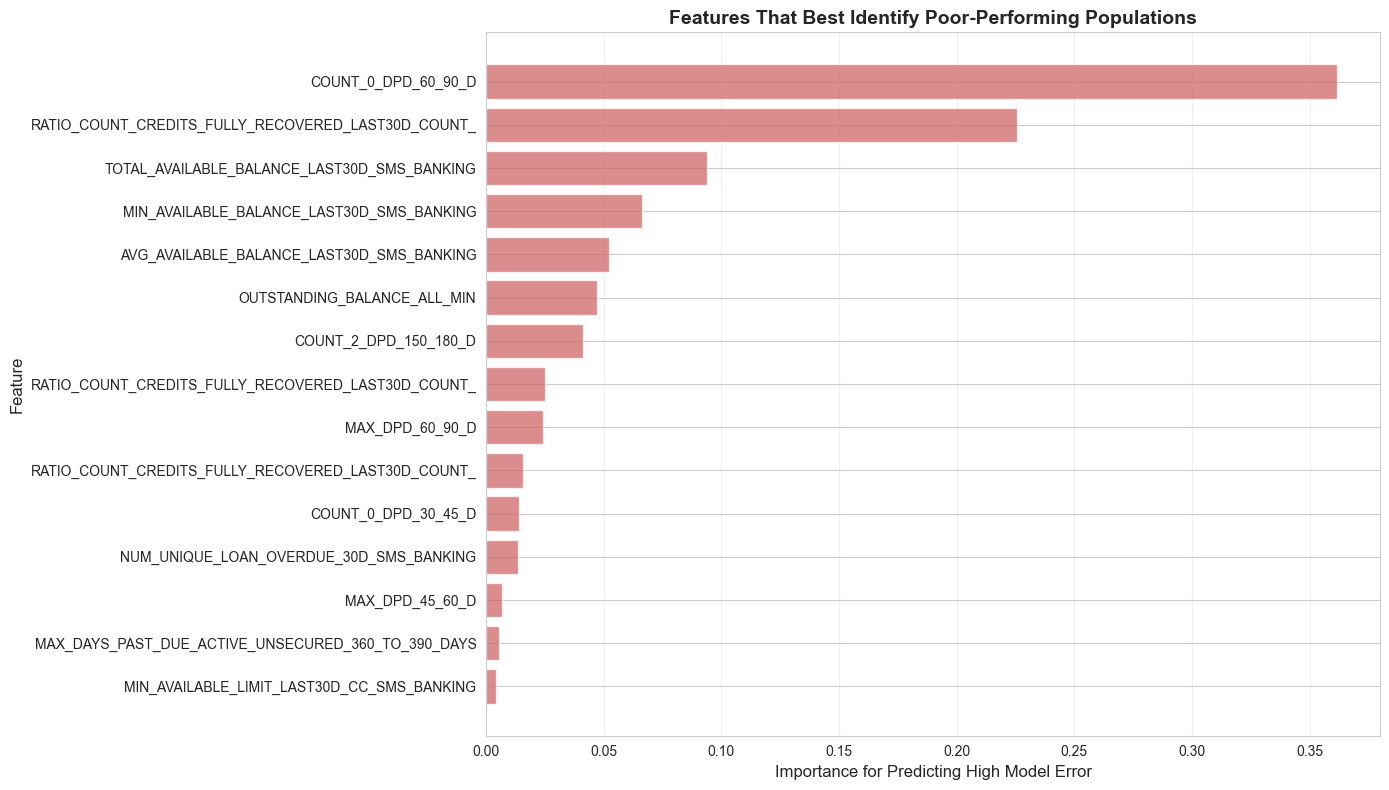

In [25]:
# Extract feature importance from the error prediction tree
error_tree_importance = pd.DataFrame({
    'Feature': top_30_features,
    'Importance': dt_error.feature_importances_
})

error_tree_importance = error_tree_importance.sort_values('Importance', ascending=False)
error_tree_importance = error_tree_importance[error_tree_importance['Importance'] > 0]

print("=" * 120)
print("FEATURES THAT BEST PREDICT WHERE MODEL PERFORMS POORLY")
print("=" * 120)
print("\nThese features identify populations where the model makes high errors:")
print(f"\n{'Rank':<6} {'Feature':<60} {'Importance':<15}")
print(f"{'-'*6} {'-'*60} {'-'*15}")

for idx, row in error_tree_importance.head(15).iterrows():
    rank = error_tree_importance.index.get_loc(idx) + 1
    print(f"{rank:<6} {row['Feature'][:58]:<60} {row['Importance']:<15.6f}")

# Visualize
plt.figure(figsize=(14, 8))
top_error_features = error_tree_importance.head(15)
bars = plt.barh(range(len(top_error_features)), top_error_features['Importance'].values, color='indianred', alpha=0.7)
plt.yticks(range(len(top_error_features)), [f[:50] for f in top_error_features['Feature'].values])
plt.xlabel('Importance for Predicting High Model Error', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Features That Best Identify Poor-Performing Populations', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 120)


In [26]:
### 7.6 Key Insights Summary


In [27]:
print("=" * 120)
print("KEY INSIGHTS: WHERE THE MODEL PERFORMS POORLY")
print("=" * 120)

print("\n📊 OVERALL PERFORMANCE:")
print(f"  - Train Error Rate: {train_errors.mean()*100:.2f}%")
print(f"  - Test Error Rate: {test_errors.mean()*100:.2f}%")
print(f"  - Model shows consistent error rates across train and test (good generalization)")

print("\n🎯 POPULATIONS WITH CONSISTENTLY POOR PERFORMANCE:")
if len(poor_performance_df) > 0:
    print(f"  - Identified {len(poor_performance_df)} population segments with ≥30% error on BOTH train and test")
    print(f"  - Worst performing population has {poor_performance_df.iloc[0]['avg_error']*100:.1f}% average error rate")
    print(f"  - These populations represent significant model weaknesses, not overfitting")
else:
    print(f"  - No populations with ≥30% error on both train and test")
    print(f"  - Highest error populations identified in leaf analysis above")

print("\n🔍 KEY CHARACTERISTICS OF POOR-PERFORMING POPULATIONS:")
print("\nFrom decision tree analysis, populations with high errors typically have:")

# Analyze the worst leaves
top_poor_leaves = leaf_df.head(3)
for idx, row in top_poor_leaves.iterrows():
    conditions = get_empirical_conditions(combined_df[top_30_features], row['mask'], top_30_features)
    print(f"\n  Population Segment (Leaf {row['node_id']}) - {row['high_error_rate']*100:.1f}% high error rate:")
    for cond in conditions[:2]:  # Show first 2 features
        print(f"    • {cond}")

print("\n📈 FEATURES DRIVING POOR PERFORMANCE:")
print("\nThe following features are most predictive of where the model struggles:")
for idx, row in error_tree_importance.head(5).iterrows():
    print(f"  {error_tree_importance.index.get_loc(idx) + 1}. {row['Feature'][:70]}")

print("\n⚠️  COMMON PATTERNS IN POOR-PERFORMING POPULATIONS:")
# Analyze common characteristics
poor_leaf_ids = leaf_df.head(5)['node_id'].tolist()
poor_populations = combined_df[combined_df['leaf_id'].isin(poor_leaf_ids)]

print(f"\n  Actual Class 1 Rate in Poor Populations: {poor_populations['actual'].mean()*100:.2f}%")
print(f"  Predicted Class 1 Rate in Poor Populations: {poor_populations['predicted'].mean()*100:.2f}%")
print(f"  Calibration Gap: {(poor_populations['predicted'].mean() - poor_populations['actual'].mean())*100:.2f} percentage points")

# Check if model under or over predicts
if poor_populations['predicted'].mean() < poor_populations['actual'].mean():
    print(f"\n  ⚠️ Model tends to UNDER-PREDICT risk in these populations")
    print(f"     This means the model is missing defaults in these segments")
else:
    print(f"\n  ⚠️ Model tends to OVER-PREDICT risk in these populations")
    print(f"     This means the model is being too conservative in these segments")

print("\n💡 RECOMMENDATIONS:")
print("  1. Investigate populations with missing/invalid DPD features (COUNT_0_DPD_60_90_D = -99999)")
print("  2. Consider feature engineering for low credit recovery ratio populations")
print("  3. Evaluate if separate models needed for populations with limited banking data")
print("  4. Review data quality for features with -99999 values (missingness handling)")
print("  5. Consider calibration techniques to reduce prediction gaps in identified segments")

print("\n" + "=" * 120)


KEY INSIGHTS: WHERE THE MODEL PERFORMS POORLY

📊 OVERALL PERFORMANCE:
  - Train Error Rate: 24.32%
  - Test Error Rate: 24.37%
  - Model shows consistent error rates across train and test (good generalization)

🎯 POPULATIONS WITH CONSISTENTLY POOR PERFORMANCE:
  - Identified 1 population segments with ≥30% error on BOTH train and test
  - Worst performing population has 32.8% average error rate
  - These populations represent significant model weaknesses, not overfitting

🔍 KEY CHARACTERISTICS OF POOR-PERFORMING POPULATIONS:

From decision tree analysis, populations with high errors typically have:

  Population Segment (Leaf 5) - 35.3% high error rate:
    • MAX_DPD_60_90_D: [-99999.0000, -99999.0000]
    • COUNT_0_DPD_45_60_D: [-99999.0000, -99999.0000]

  Population Segment (Leaf 8) - 30.3% high error rate:
    • MAX_DPD_60_90_D: [-99999.0000, 13.0000]
    • COUNT_0_DPD_45_60_D: [-99999.0000, 15.0000]

  Population Segment (Leaf 16) - 28.6% high error rate:
    • MAX_DPD_60_90_D: [-

In [28]:
# moin